<h1 style="font-size:22px;color:red"> Traitement des données </h1>

<h2 style="font-size:19px;color:blue"> Import des fichiers et modules nécessaires </h2>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import chi2_contingency
import datetime
import warnings
warnings.simplefilter('ignore')
from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import anderson
from scipy.stats import levene
from scipy.stats import f_oneway
from scipy.stats import kruskal
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr
import scikit_posthocs as sp
from sklearn.linear_model import LinearRegression

In [5]:
customers = pd.read_csv('customers.csv', sep=';')
products = pd.read_csv('products.csv', sep=';')
transactions = pd.read_csv('transactions.csv', sep=';')

<h2 style="font-size:19px;color:blue"> Vue d'ensemble des dataframe </h2>

In [6]:
print(customers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB
None


In [7]:
print(products.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB
None


In [8]:
print(transactions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679332 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB
None


In [9]:
print(customers.describe())

             birth
count  8623.000000
mean   1978.280877
std      16.919535
min    1929.000000
25%    1966.000000
50%    1979.000000
75%    1992.000000
max    2004.000000


In [10]:
print(products.describe())

             price        categ
count  3287.000000  3287.000000
mean     21.856641     0.370246
std      29.847908     0.615387
min      -1.000000     0.000000
25%       6.990000     0.000000
50%      13.060000     0.000000
75%      22.990000     1.000000
max     300.000000     2.000000


- Le dataframe PRODUCTS contient des valeurs de prix négatifs (-1)

In [11]:
print(transactions.describe())

       id_prod              date session_id client_id
count   679532            679332     679532    679532
unique    3267            497671     342316      8602
top      1_369  24/01/2023 13:46        s_0    c_1609
freq      2252                 7        200     25488


<h2 style="font-size:19px;color:blue"> Exploration des valeurs manquantes	 </h2>

In [12]:
print(customers.isnull().sum()) # Aucune valeurs manquantes

client_id    0
sex          0
birth        0
dtype: int64


In [13]:
print(products.isnull().sum()) # Aucune valeurs manquantes

id_prod    0
price      0
categ      0
dtype: int64


In [14]:
print(transactions.isnull().sum()) # 200 dates manquantes

id_prod         0
date          200
session_id      0
client_id       0
dtype: int64


In [15]:
transactions.head(25)

,id_prod,date,session_id,client_id
0,0_1518,20/05/2022 13:21,s_211425,c_103
1,1_251,02/02/2022 07:55,s_158752,c_8534
2,0_1277,18/06/2022 15:44,s_225667,c_6714
3,2_209,24/06/2021 04:19,s_52962,c_6941
4,0_1509,11/01/2023 08:22,s_325227,c_4232
5,0_1418,20/10/2022 15:59,s_285425,c_1478
6,0_1475,03/06/2022 04:45,s_218033,c_7782
7,0_2110,26/06/2021 14:48,s_54122,c_7456
8,0_1156,27/12/2022 12:27,s_318058,c_7363
9,1_299,29/11/2021 15:54,s_126880,c_1847


##### Stockage des date NaN dans un dataframe transactions_nan

In [16]:
transactions_nan = transactions[transactions['date'].isnull()]
transactions_nan

,id_prod,date,session_id,client_id
3019,T_0,NaN,s_0,ct_0
5138,T_0,NaN,s_0,ct_0
9668,T_0,NaN,s_0,ct_1
10728,T_0,NaN,s_0,ct_0
15292,T_0,NaN,s_0,ct_0
...,...,...,...,...
657830,T_0,NaN,s_0,ct_0
662081,T_0,NaN,s_0,ct_1
670680,T_0,NaN,s_0,ct_1
671647,T_0,NaN,s_0,ct_1


<h2 style="font-size:19px;color:blue"> Vérification de la présence de lignes doubles </h2>

In [17]:
print("Il y a",transactions.duplicated().sum(),"lignes en double dans la table TRANSACTIONS")
print("Il y a",products.duplicated().sum(),"lignes en double dans la table PRODUCTS")
print("Il y a",customers.duplicated().sum(),"lignes en double dans la table CUSTOMERS")

Il y a 222 lignes en double dans la table TRANSACTIONS
Il y a 0 lignes en double dans la table PRODUCTS
Il y a 0 lignes en double dans la table CUSTOMERS


<h2 style="font-size:19px;color:blue"> Jointure des tables 'products' et 'transactions' </h2>

In [18]:
transac_prod = pd.merge(transactions, products, how="left")

In [19]:
print(transac_prod.info()) # On observe une différence de NaN entre les colonnes price et categ

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679532 entries, 0 to 679531
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_prod     679532 non-null  object 
 1   date        679332 non-null  object 
 2   session_id  679532 non-null  object 
 3   client_id   679532 non-null  object 
 4   price       679311 non-null  float64
 5   categ       679311 non-null  float64
dtypes: float64(2), object(4)
memory usage: 36.3+ MB
None


<h2 style="font-size:19px;color:blue"> Traitement des valeurs de prix négatifs </h2>

In [20]:
price_negatif = transac_prod[transac_prod['price']<=0]
print(price_negatif)

       id_prod date session_id client_id  price  categ
3019       T_0  NaN        s_0      ct_0   -1.0    0.0
5138       T_0  NaN        s_0      ct_0   -1.0    0.0
9668       T_0  NaN        s_0      ct_1   -1.0    0.0
10728      T_0  NaN        s_0      ct_0   -1.0    0.0
15292      T_0  NaN        s_0      ct_0   -1.0    0.0
...        ...  ...        ...       ...    ...    ...
657830     T_0  NaN        s_0      ct_0   -1.0    0.0
662081     T_0  NaN        s_0      ct_1   -1.0    0.0
670680     T_0  NaN        s_0      ct_1   -1.0    0.0
671647     T_0  NaN        s_0      ct_1   -1.0    0.0
679180     T_0  NaN        s_0      ct_1   -1.0    0.0

[200 rows x 6 columns]


- Ces prix négatifs correspondent à l'id_prod T_0, ainsi qu'à l'id_client ct_0 et ct_1

##### Aperçu des valeurs ct_0 et ct_1 dans le df 'customers'

In [22]:
customers_ct = customers[customers['client_id'].isin(['ct_0', 'ct_1'])]
customers_ct

,client_id,sex,birth
2735,ct_0,f,2001
8494,ct_1,m,2001


- Les lignes ct_1 et ct_0 correspondent à un id_prod T_0 ainsi que des valeurs de prix, session et catégories qui ne pourront être exploité dans l'analyse.
- Nous décidons de supprimer ces lignes de tout nos dataframes

In [23]:
transac_prod = transac_prod[(transac_prod['client_id'] != 'ct_1') & (transac_prod['client_id'] !='ct_0')]
transactions = transactions[(transactions['client_id'] != 'ct_1') & (transactions['client_id'] !='ct_0')]
customers = customers[(customers['client_id'] != 'ct_1') & (customers['client_id'] != 'ct_0')]

##### Création d'un dataframe regroupant les produits dont la valeur de prix est manquante

In [24]:
price_nan = transac_prod[transac_prod.price.isna()==True]
print(price_nan.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 2633 to 677996
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_prod     221 non-null    object 
 1   date        221 non-null    object 
 2   session_id  221 non-null    object 
 3   client_id   221 non-null    object 
 4   price       0 non-null      float64
 5   categ       0 non-null      float64
dtypes: float64(2), object(4)
memory usage: 12.1+ KB
None


<h2 style="font-size:19px;color:blue"> Imputation des valeurs de prix manquantes </h2>

In [25]:
price_nan.head()

,id_prod,date,session_id,client_id,price,categ
2633,0_2245,23/09/2022 07:22,s_272266,c_4746,NaN,NaN
10106,0_2245,23/07/2022 09:24,s_242482,c_6713,NaN,NaN
11727,0_2245,03/12/2022 03:26,s_306338,c_5108,NaN,NaN
15675,0_2245,16/08/2021 11:33,s_76493,c_1391,NaN,NaN
16377,0_2245,16/07/2022 05:53,s_239078,c_7954,NaN,NaN


In [26]:
print(price_nan.groupby(price_nan.id_prod).count()) 

         date  session_id  client_id  price  categ
id_prod                                           
0_2245    221         221        221      0      0


- Après exploration du dataframe, nous remarquons que les valeurs de prix manquantes correspondent à l'id_prod 0_2245.
- On remarque également que pour l'entièreté du dataframe, le premier chiffre de l'id_prod (0, 1 ou 2) correspond à la catégorie du produit (categ) 

In [27]:
for index, row in products.iterrows():
    print(row)

id_prod    0_1421
price       19.99
categ           0
Name: 0, dtype: object
id_prod    0_1368
price        5.13
categ           0
Name: 1, dtype: object
id_prod    0_731
price      17.99
categ          0
Name: 2, dtype: object
id_prod    1_587
price       4.99
categ          1
Name: 3, dtype: object
id_prod    0_1507
price        3.99
categ           0
Name: 4, dtype: object
id_prod    0_1163
price        9.99
categ           0
Name: 5, dtype: object
id_prod    1_463
price      36.99
categ          1
Name: 6, dtype: object
id_prod    0_2157
price       34.99
categ           0
Name: 7, dtype: object
id_prod    0_1915
price       16.99
categ           0
Name: 8, dtype: object
id_prod    0_389
price      18.99
categ          0
Name: 9, dtype: object
id_prod     2_228
price      225.17
categ           2
Name: 10, dtype: object
id_prod    1_178
price      51.92
categ          1
Name: 11, dtype: object
id_prod    1_143
price       9.99
categ          1
Name: 12, dtype: object
id_prod    1_3

- Concernant les valeurs manquantes de la colonne 'price', nous avons 2 options :
1. Suppression des lignes 0_2245 de la colonne 'id_prod' du dataframe
2. Attribuer une valeur au prix

##### Choix de l'option N°2 : Création d'un histograme afin de connaître la distribution des prix

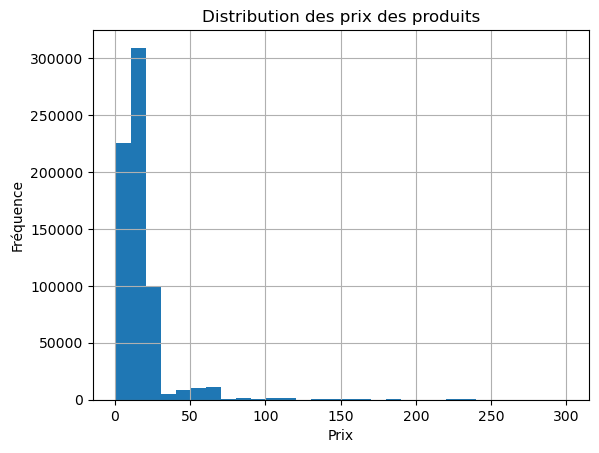

In [28]:
transac_prod['price'].hist(bins=30)
plt.xlabel('Prix')
plt.ylabel('Fréquence')
plt.title('Distribution des prix des produits')
plt.show()

- La distribution étant asymétrique nous préférons attribuer la valeur médiane des prix de la catégorie 0 des produits

In [29]:
prod_cat_0 = transac_prod[transac_prod['categ']==0]
med_price_cat_0 = prod_cat_0['price'].median()
print(med_price_cat_0)

9.99


In [30]:
transac_prod['price']=transac_prod['price'].fillna(med_price_cat_0)

# Vérification
verif_price_med = transac_prod[transac_prod['id_prod'] == '0_2245']
print(verif_price_med)

       id_prod              date session_id client_id  price  categ
2633    0_2245  23/09/2022 07:22   s_272266    c_4746   9.99    NaN
10106   0_2245  23/07/2022 09:24   s_242482    c_6713   9.99    NaN
11727   0_2245  03/12/2022 03:26   s_306338    c_5108   9.99    NaN
15675   0_2245  16/08/2021 11:33    s_76493    c_1391   9.99    NaN
16377   0_2245  16/07/2022 05:53   s_239078    c_7954   9.99    NaN
...        ...               ...        ...       ...    ...    ...
669730  0_2245  25/08/2021 09:06    s_80395     c_131   9.99    NaN
670682  0_2245  06/03/2022 19:59   s_175311    c_4167   9.99    NaN
671286  0_2245  16/05/2022 11:35   s_209381    c_4453   9.99    NaN
675679  0_2245  11/02/2022 09:05   s_163405    c_1098   9.99    NaN
677996  0_2245  14/12/2021 22:34   s_134446    c_4854   9.99    NaN

[221 rows x 6 columns]


<h2 style="font-size:19px;color:blue"> Imputation des catégories manquantes </h2>

In [31]:
transac_prod['categ']=transac_prod['categ'].fillna(0)
transac_prod

,id_prod,date,session_id,client_id,price,categ
0,0_1518,20/05/2022 13:21,s_211425,c_103,4.18,0.0
1,1_251,02/02/2022 07:55,s_158752,c_8534,15.99,1.0
2,0_1277,18/06/2022 15:44,s_225667,c_6714,7.99,0.0
3,2_209,24/06/2021 04:19,s_52962,c_6941,69.99,2.0
4,0_1509,11/01/2023 08:22,s_325227,c_4232,4.99,0.0
...,...,...,...,...,...,...
679527,0_1551,15/01/2022 13:05,s_150195,c_8489,12.99,0.0
679528,1_639,19/03/2022 16:03,s_181434,c_4370,10.99,1.0
679529,0_1425,20/12/2022 04:33,s_314704,c_304,12.99,0.0
679530,0_1994,16/07/2021 20:36,s_63204,c_2227,4.98,0.0


##### Nouvelle vue d'ensemble des dataframe

In [32]:
transac_prod.describe()

,price,categ
count,679332.000000,679332.000000
mean,17.452345,0.441809
std,18.326510,0.594998
min,0.620000,0.000000
25%,8.870000,0.000000
50%,13.990000,0.000000
75%,18.990000,1.000000
max,300.000000,2.000000


In [33]:
transac_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679531
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_prod     679332 non-null  object 
 1   date        679332 non-null  object 
 2   session_id  679332 non-null  object 
 3   client_id   679332 non-null  object 
 4   price       679332 non-null  float64
 5   categ       679332 non-null  float64
dtypes: float64(2), object(4)
memory usage: 36.3+ MB


In [34]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8621 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8621 non-null   object
 1   sex        8621 non-null   object
 2   birth      8621 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 269.4+ KB


In [35]:
customers.describe()

,birth
count,8621.000000
mean,1978.275606
std,16.917958
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


In [36]:
transac_prod.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
price         0
categ         0
dtype: int64

<h2 style="font-size:19px;color:blue"> Modification des types de variables </h2>

##### Modification du type de variable objet --> date

In [37]:
transac_prod['date'] = pd.to_datetime(transac_prod['date'], format='%d/%m/%Y %H:%M', errors='raise') # montre l'erreur s'il y a
transac_prod

,id_prod,date,session_id,client_id,price,categ
0,0_1518,2022-05-20 13:21:00,s_211425,c_103,4.18,0.0
1,1_251,2022-02-02 07:55:00,s_158752,c_8534,15.99,1.0
2,0_1277,2022-06-18 15:44:00,s_225667,c_6714,7.99,0.0
3,2_209,2021-06-24 04:19:00,s_52962,c_6941,69.99,2.0
4,0_1509,2023-01-11 08:22:00,s_325227,c_4232,4.99,0.0
...,...,...,...,...,...,...
679527,0_1551,2022-01-15 13:05:00,s_150195,c_8489,12.99,0.0
679528,1_639,2022-03-19 16:03:00,s_181434,c_4370,10.99,1.0
679529,0_1425,2022-12-20 04:33:00,s_314704,c_304,12.99,0.0
679530,0_1994,2021-07-16 20:36:00,s_63204,c_2227,4.98,0.0


In [38]:
transac_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679531
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
 4   price       679332 non-null  float64       
 5   categ       679332 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 36.3+ MB


##### Modification type variable 'categ' float --> int

In [39]:
transac_prod['categ'] = transac_prod['categ'].astype(int)
transac_prod

,id_prod,date,session_id,client_id,price,categ
0,0_1518,2022-05-20 13:21:00,s_211425,c_103,4.18,0
1,1_251,2022-02-02 07:55:00,s_158752,c_8534,15.99,1
2,0_1277,2022-06-18 15:44:00,s_225667,c_6714,7.99,0
3,2_209,2021-06-24 04:19:00,s_52962,c_6941,69.99,2
4,0_1509,2023-01-11 08:22:00,s_325227,c_4232,4.99,0
...,...,...,...,...,...,...
679527,0_1551,2022-01-15 13:05:00,s_150195,c_8489,12.99,0
679528,1_639,2022-03-19 16:03:00,s_181434,c_4370,10.99,1
679529,0_1425,2022-12-20 04:33:00,s_314704,c_304,12.99,0
679530,0_1994,2021-07-16 20:36:00,s_63204,c_2227,4.98,0


<h2 style="font-size:19px;color:blue"> Jointure pour analyse du dataframe </h2>

In [40]:
print("Il y a",customers.duplicated().sum(),"lignes en double dans la table CUSTOMERS")
print("Il y a",transac_prod.duplicated().sum(),"lignes en double dans la table TRANSAC_PROD")

Il y a 0 lignes en double dans la table CUSTOMERS
Il y a 24 lignes en double dans la table TRANSAC_PROD


In [41]:
doublons = transac_prod.duplicated()
print(transac_prod[doublons])

       id_prod                date session_id client_id  price  categ
120797   1_444 2023-02-28 01:12:00   s_347964    c_5185  12.61      1
143329  0_1430 2021-06-03 08:14:00    s_43423    c_1286  16.47      0
152206   1_381 2022-04-13 08:08:00   s_193365    c_1609  15.99      1
155433   1_434 2022-12-21 15:03:00   s_315368    c_4015  15.87      1
194791  0_1123 2021-04-29 21:21:00    s_27641    c_4459  12.99      0
345890   1_381 2022-07-13 08:08:00   s_237704    c_1609  15.99      1
364856   1_417 2021-11-16 01:40:00   s_120267     c_707  20.99      1
446280   1_475 2021-09-21 05:52:00    s_93095    c_5978  20.99      1
448554   1_381 2021-05-13 08:08:00    s_33887    c_1609  15.99      1
462727   1_434 2022-10-21 15:03:00   s_285889    c_4015  15.87      1
552452  0_1638 2021-10-07 05:27:00   s_101193    c_6815   5.46      0
560619  0_1430 2022-09-03 08:14:00   s_262588    c_1286  16.47      0
570303   1_383 2021-12-25 20:48:00   s_139977    c_8439  28.99      1
575003  0_1399 2021-

- Le dataframe ne présente aucun doublon et est prêt pour jointure finale et analyse des données

##### Jointure des tables transac_prod et customers pour dataframe complet

In [42]:
transac_prod_cust = pd.merge(transac_prod, customers, how='left')
transac_prod_cust

,id_prod,date,session_id,client_id,price,categ,sex,birth
0,0_1518,2022-05-20 13:21:00,s_211425,c_103,4.18,0,f,1986
1,1_251,2022-02-02 07:55:00,s_158752,c_8534,15.99,1,m,1988
2,0_1277,2022-06-18 15:44:00,s_225667,c_6714,7.99,0,f,1968
3,2_209,2021-06-24 04:19:00,s_52962,c_6941,69.99,2,m,2000
4,0_1509,2023-01-11 08:22:00,s_325227,c_4232,4.99,0,m,1980
...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:00,s_150195,c_8489,12.99,0,f,1951
679328,1_639,2022-03-19 16:03:00,s_181434,c_4370,10.99,1,f,1977
679329,0_1425,2022-12-20 04:33:00,s_314704,c_304,12.99,0,f,1988
679330,0_1994,2021-07-16 20:36:00,s_63204,c_2227,4.98,0,m,1986


In [43]:
transac_prod_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679331
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
 4   price       679332 non-null  float64       
 5   categ       679332 non-null  int32         
 6   sex         679332 non-null  object        
 7   birth       679332 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 44.1+ MB


In [44]:
print(transac_prod_cust.isnull().sum())

id_prod       0
date          0
session_id    0
client_id     0
price         0
categ         0
sex           0
birth         0
dtype: int64


In [45]:
transac_prod_cust.describe()

,price,categ,birth
count,679332.000000,679332.000000,679332.000000
mean,17.452345,0.441809,1977.811139
std,18.326510,0.594998,13.574553
min,0.620000,0.000000,1929.000000
25%,8.870000,0.000000,1970.000000
50%,13.990000,0.000000,1980.000000
75%,18.990000,1.000000,1987.000000
max,300.000000,2.000000,2004.000000


- On observe une très large distribution des prix, allant de 0.62 à 300€. Nous allons désormais analyser les outliners, mais avant celà, nous voulons nous assurer que les prix de chaque produit est bien unique.

<h2 style="font-size:19px;color:blue"> Vérification des prix uniques </h2>

In [46]:
def check_price_consistency(df):
  
    grouped = df.groupby('id_prod')
    inconsistent_ids = []

    for name, group in grouped:
        unique_prices = group['price'].unique()
        if len(unique_prices) > 1:
            inconsistent_ids.append(name)

    # Si la liste est vide, tous les id_prod ont des prix uniques
    if len(inconsistent_ids) == 0:
        print("Tous les identifiants de produit ont des prix uniques.")
    else:
        # Sinon : listing des id_prod avec des prix multiples
        print("Les identifiants de produit suivants ont des prix multiples :")
        print(inconsistent_ids)

check_price_consistency(transac_prod_cust)

Tous les identifiants de produit ont des prix uniques.


- Suite au nettoyage de notre dataframe, nous allons désormais analyser les outliners afin de detecter d'éventuelles valeurs aberrantes. Les détecter, les trier et les comprendre permettra de rendre les données le plus exploitable possible pour les futures analyses. 

<h1 style="font-size:22px;color:red"> Analyse des outliners </h1>

<h2 style="font-size:19px;color:blue"> Méthode Inter Quartile Range (IQR) </h2>

- Approche courrament utilisé dans le domaine scientifique afin de déterminer des outliners
- IQR = Quartile3 - Quartile1
- La borne supérieure est délimitée par : Q3 + 1.5 * IQR
- La borne inférieure : Q1 - 1.5 * IQR
- Les valeurs hors des limites sont potentiellement considérés comme des outliners. Néanmoins, un outliner n'est pas forcément une valeur abbérante.

In [47]:
transac_prod_cust.sort_values(by='price', inplace=True) 
price_Q1 = np.percentile(transac_prod_cust['price'], 25) 
price_Q3 = np.percentile(transac_prod_cust['price'], 75)
price_IQR = price_Q3 - price_Q1 # Calcul de l'IQR
print("La valeur du premier quartile (Q1) est de", price_Q1)
print("La valeur du troisième quartile (Q3) est de", price_Q3)
print("IQR =", price_IQR)

La valeur du premier quartile (Q1) est de 8.87
La valeur du troisième quartile (Q3) est de 18.99
IQR = 10.12


##### Détermination des bornes inférieures et supérieures

In [48]:
price_IQR_inf = price_Q1 - (1.5*price_IQR) # Calcul de la borne inférieure. Les prix n'étant jamais négatif, la borne inférieure n'est pas utilise dans l'analyse de cet échantillon.
price_IQR_sup = price_Q3 + (1.5*price_IQR) # Calcul de la borne supérieure
print("La borne inférieure est égale à :", round(price_IQR_inf, 2))
print("La borne supérieure est égale à :", round(price_IQR_sup, 2))

La borne inférieure est égale à : -6.31
La borne supérieure est égale à : 34.17


##### Tableau des outliners par approche IQR

In [49]:
print(transac_prod_cust[transac_prod_cust['price'] > price_IQR_sup])

       id_prod                date session_id client_id   price  categ sex  \
365874   1_306 2022-12-07 16:04:00   s_308484    c_3090   34.18      1   f   
345961   1_306 2021-06-16 12:02:00    s_49456    c_3433   34.18      1   f   
25852    1_306 2023-02-16 12:02:00   s_342422    c_3433   34.18      1   f   
387723   1_306 2022-02-12 14:32:00   s_164041    c_1925   34.18      1   m   
201826   1_306 2022-08-07 16:04:00   s_249808    c_3090   34.18      1   f   
...        ...                 ...        ...       ...     ...    ...  ..   
91228      2_2 2022-08-12 08:44:00   s_252144    c_5237  300.00      2   m   
615713     2_2 2021-12-04 15:45:00   s_129351    c_4958  300.00      2   m   
594923     2_2 2022-11-28 21:24:00   s_304241     c_659  300.00      2   f   
350936     2_2 2022-06-07 06:52:00   s_220074    c_4958  300.00      2   m   
36594      2_2 2022-12-07 06:52:00   s_308301    c_4958  300.00      2   m   

        birth  
365874   1974  
345961   1982  
25852    1982  

- La méthode IQR considère 42606 lignes comme étant des outliners, soit toutes lignes dont la valeur de prix se situe entre 34,18€ et 300€. 
- Etant donné la distribution très étalée des prix des produits, cette méthode ne permet pas de déterminer avec précisions les outliners. 

<h2 style="font-size:19px;color:blue"> Méthode Z-Score </h2>

- Le Z-score aide à comprendre à quelle distance de la moyenne se trouve le point de données. En définissant une valeur seuil, on peut déterminer les outliners. La valeur seuil dépend de la marge d'erreur souhaitée. Dans le domaine scientifique, la marge d'erreur de 5% est la plus répandue, et correspond à un Z-score de 1.96 (source : https://www.sjsu.edu/faculty/gerstman/StatPrimer/z-two-tails.pdf).
- Z = (x – μ)/σ ; où Z : Z-score ; x : point de données ; μ : moyenne de l'échantillon ; σ : écart-type
- Un Z-score élevé révèle une valeur supérieure à la normale, tandis qu'un Z-score inférieur à 0 représente une valeur inférieur à la moyenne.
- Enfin, plus le Z-score sera proche de 0, plus la valeur sera proche de la moyenne de l'échantillon.

##### Analyse par Z-score 5% (1.96)

In [50]:
outliners_z = transac_prod_cust.copy()
outliners_z['zscore'] = stats.zscore(outliners_z['price'])
print(outliners_z[outliners_z['zscore'] > 1.96])

       id_prod                date session_id client_id   price  categ sex  \
540646    1_88 2021-08-21 23:29:00    s_78942     c_477   53.42      1   m   
322452    1_88 2022-03-17 13:46:00   s_180402    c_5655   53.42      1   f   
189740    1_88 2022-10-14 12:07:00   s_282378    c_4817   53.42      1   f   
628153    1_88 2021-08-13 20:21:00    s_75331    c_1520   53.42      1   f   
417036    1_88 2023-01-05 02:44:00   s_322161    c_8499   53.42      1   f   
...        ...                 ...        ...       ...     ...    ...  ..   
91228      2_2 2022-08-12 08:44:00   s_252144    c_5237  300.00      2   m   
615713     2_2 2021-12-04 15:45:00   s_129351    c_4958  300.00      2   m   
594923     2_2 2022-11-28 21:24:00   s_304241     c_659  300.00      2   f   
350936     2_2 2022-06-07 06:52:00   s_220074    c_4958  300.00      2   m   
36594      2_2 2022-12-07 06:52:00   s_308301    c_4958  300.00      2   m   

        birth     zscore  
540646   1945   1.962604  
322452   

##### Z-score 1% (2.58)

In [51]:
print(outliners_z[outliners_z['zscore'] > 2.58])

       id_prod                date session_id client_id   price  categ sex  \
305983   2_148 2021-05-01 16:06:00    s_28460    c_6233   64.85      2   f   
546530   2_148 2022-11-06 02:55:00   s_293354    c_3611   64.85      2   f   
585252   2_148 2023-01-10 00:14:00   s_324614    c_6173   64.85      2   m   
223088   2_148 2021-04-25 10:39:00    s_25497    c_6032   64.85      2   f   
345008   2_148 2021-11-14 08:02:00   s_119430    c_5456   64.85      2   f   
...        ...                 ...        ...       ...     ...    ...  ..   
91228      2_2 2022-08-12 08:44:00   s_252144    c_5237  300.00      2   m   
615713     2_2 2021-12-04 15:45:00   s_129351    c_4958  300.00      2   m   
594923     2_2 2022-11-28 21:24:00   s_304241     c_659  300.00      2   f   
350936     2_2 2022-06-07 06:52:00   s_220074    c_4958  300.00      2   m   
36594      2_2 2022-12-07 06:52:00   s_308301    c_4958  300.00      2   m   

        birth     zscore  
305983   1954   2.586291  
546530   

- Même en considérant les 1% des plus grandes valeurs de prix, plus de 17 000 lignes sont concernées. Tout comme l'approche IQR, la méthode du Z-score ne permet pas de déterminer les outliners avec précisions, car la distribution des prix est très étalée.
- Pour mieux comprendre cette distribution des prix, nous allons poursuivre notre analyse en vérifiant la répartition des prix en fonction des différentes catégories de produits.

<h2 style="font-size:19px;color:blue"> Répartition des prix par catégories de produits </h2>

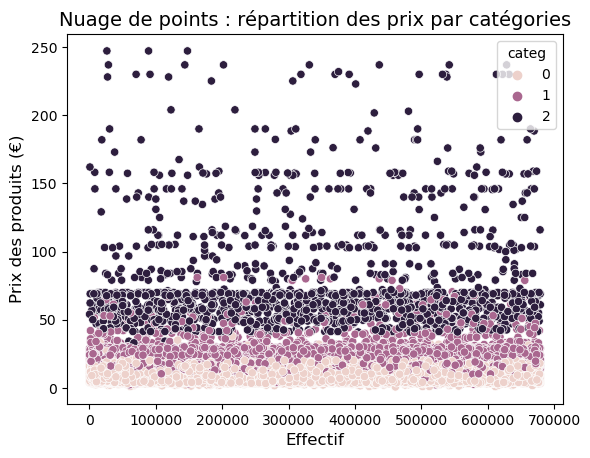

In [52]:
nuage_point_3000 = transac_prod_cust.sample(n=30000)
sns.scatterplot(data=nuage_point_3000, x=nuage_point_3000.index, y='price', hue='categ')
plt.title("Nuage de points : répartition des prix par catégories", fontsize=14)
plt.xlabel("Effectif", fontsize=12)
plt.ylabel("Prix des produits (€)", fontsize=12)
plt.show()

- Nous observons que chaque catégorie de produits est associé à une range de prix

In [53]:
categ_0 = transac_prod_cust[transac_prod_cust['categ']==0]
categ_0.describe()

,price,categ,birth
count,415680.000000,415680.0,415680.000000
mean,10.637843,0.0,1978.102384
std,4.932238,0.0,11.209482
min,0.620000,0.0,1929.000000
25%,6.290000,0.0,1973.000000
50%,9.990000,0.0,1980.000000
75%,14.450000,0.0,1986.000000
max,40.990000,0.0,2004.000000


- La catégorie 0 représente des biens compris entre 0.62 et 40.99€

In [54]:
categ_1 = transac_prod_cust[transac_prod_cust['categ']==1]
categ_1.describe()

,price,categ,birth
count,227169.000000,227169.0,227169.000000
mean,20.485730,1.0,1974.348762
std,7.584894,0.0,15.495910
min,2.000000,1.0,1929.000000
25%,15.810000,1.0,1964.000000
50%,19.080000,1.0,1975.000000
75%,24.980000,1.0,1986.000000
max,80.990000,1.0,2004.000000


- La catégorie 1 représente des biens compris entre 2€ et 80.99€

In [55]:
categ_2 = transac_prod_cust[transac_prod_cust['categ']==2]
categ_2.describe()

,price,categ,birth
count,36483.000000,36483.0,36483.000000
mean,76.207412,2.0,1996.051969
std,39.749015,0.0,9.798143
min,30.990000,2.0,1929.000000
25%,53.990000,2.0,1994.000000
50%,62.830000,2.0,1999.000000
75%,73.720000,2.0,2002.000000
max,300.000000,2.0,2004.000000


- La catégorie 2 représente des biens compris entre 30.99 et 300€

##### Box-plot de la répartition des prix par catégorie

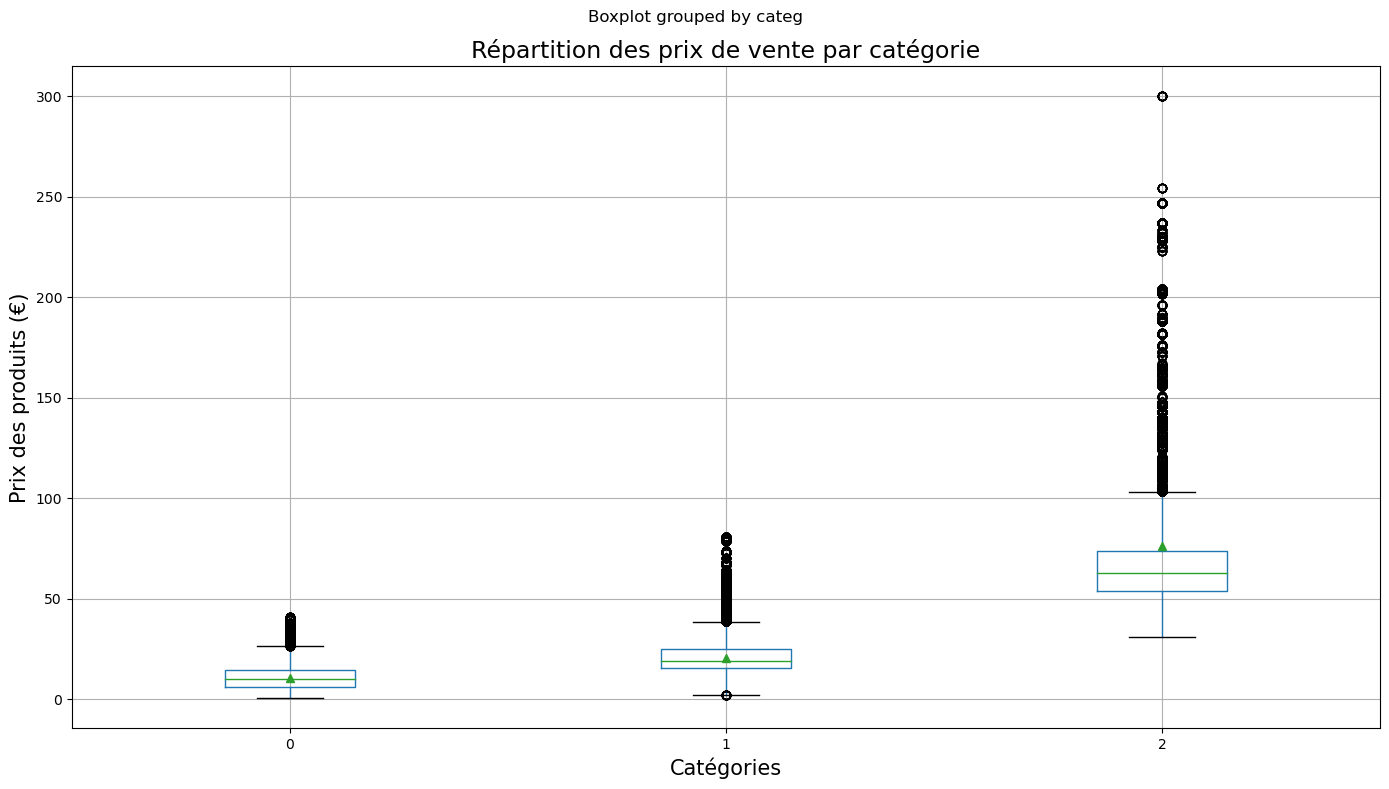

In [56]:
plt.rcParams["figure.figsize"] = [14, 8]
plt.rcParams["figure.autolayout"] = True
transac_prod_cust.boxplot(column='price', by='categ', showmeans=True)
plt.title('Répartition des prix de vente par catégorie', fontsize=17)
plt.xlabel('Catégories', fontsize=15)
plt.ylabel('Prix des produits (€)', fontsize=15)
plt.show()

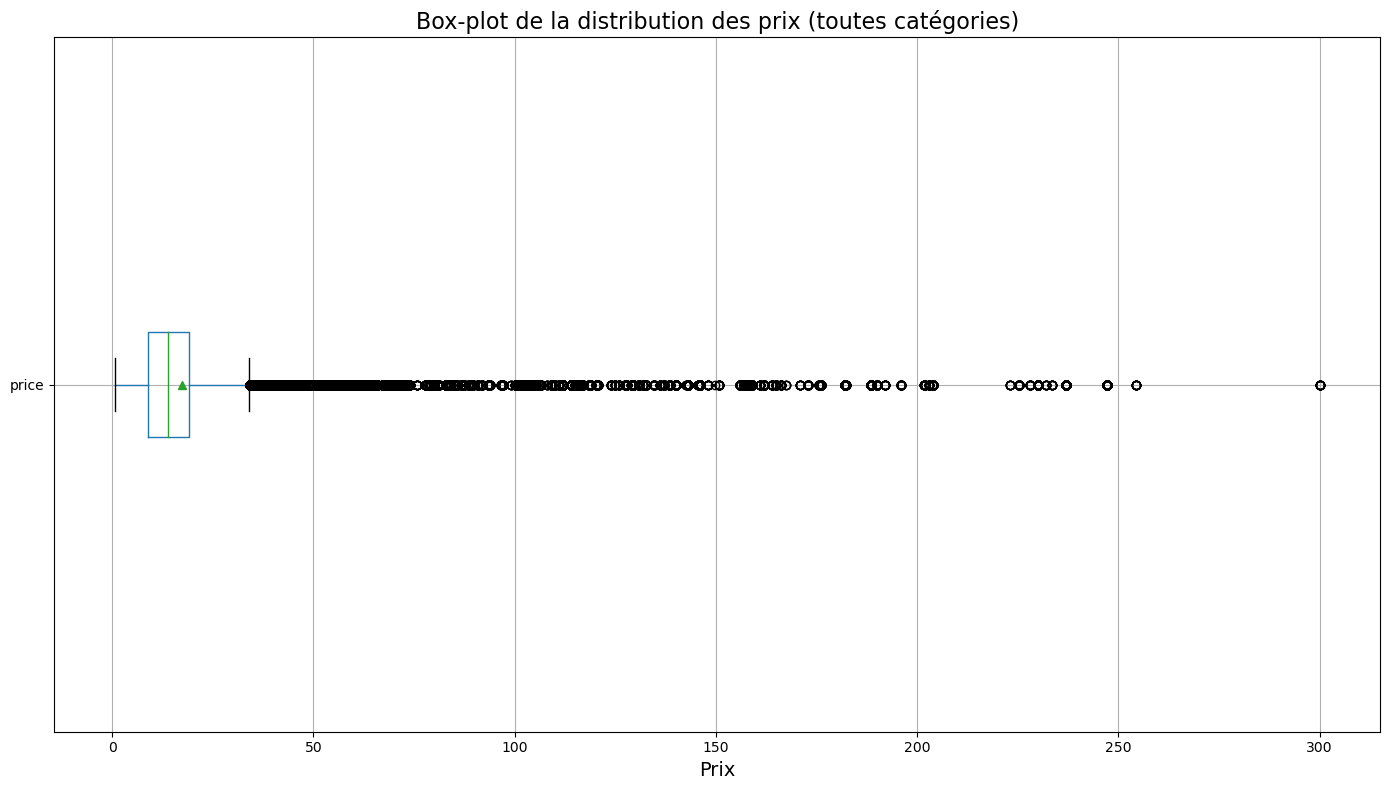

In [57]:
plt.rcParams["figure.figsize"] = [14, 8]
plt.rcParams["figure.autolayout"] = True
transac_prod_cust.boxplot(column='price', vert=False, showmeans=True)

plt.title('Box-plot de la distribution des prix (toutes catégories)', fontsize = 16)
plt.xlabel('Prix', fontsize = 14)

plt.show()

In [58]:
transac_prod_cust.describe()

,price,categ,birth
count,679332.000000,679332.000000,679332.000000
mean,17.452345,0.441809,1977.811139
std,18.326510,0.594998,13.574553
min,0.620000,0.000000,1929.000000
25%,8.870000,0.000000,1970.000000
50%,13.990000,0.000000,1980.000000
75%,18.990000,1.000000,1987.000000
max,300.000000,2.000000,2004.000000


- Le graphique à moustache permet d'avoir une vue d'ensemble de la distribution des prix de notre boutique en ligne et facilite la compréhension des valeurs aberrantes détectées par les méthodes IQR et Z-score. 
- Les statistiques descriptives montrent que le prix moyen de tous les livres vendus est de 17,46€, avec un quartile inférieur à 8,87€ pour 25% des livres et un quartile supérieur à 18,99€ pour les 25% les plus chers. 
- La moitié des livres vendus ont un prix inférieur à 13,99€, tandis que l'autre moitié a un prix supérieur. Le livre le plus cher coûte 300€, tandis que le livre le moins cher coûte seulement 0,62€. 
- En raison de la dispersion importante des données de prix et de la forte proportion de livres à bas prix par rapport aux livres coûteux, les méthodes de détection des valeurs aberrantes se révèlent inefficaces.

<h1 style="font-size:21px;color:red"> Informations sur le chiffre d'affaire </h1>

<h2 style="font-size:19px;color:blue"> Chiffre d'affaire et transactions </h2>

In [59]:
nb_transac = transac_prod_cust['price'].count()
print("Il y a eu un total de",nb_transac, "transactions")

Il y a eu un total de 679332 transactions


In [60]:
CA_tot = sum(transac_prod_cust['price'])
print("Le chiffre d'affaire est de", round(CA_tot, 2), "€")

Le chiffre d'affaire est de 11855936.47 €


<h2 style="font-size:19px;color:blue"> Nombre de transactions par catégorie </h2>

In [61]:
len_transac_0 = len(transac_prod_cust[(transac_prod_cust['categ'] == 0)])
len_transac_1 = len(transac_prod_cust[(transac_prod_cust['categ'] == 1)])
len_transac_2 = len(transac_prod_cust[(transac_prod_cust['categ'] == 2)])

print("Il y a", len_transac_0, "transactions de catégorie 0")
print("Il y a", len_transac_1, "transactions de catégorie 1")
print("Il y a", len_transac_2, "transactions de catégorie 2")

Il y a 415680 transactions de catégorie 0
Il y a 227169 transactions de catégorie 1
Il y a 36483 transactions de catégorie 2


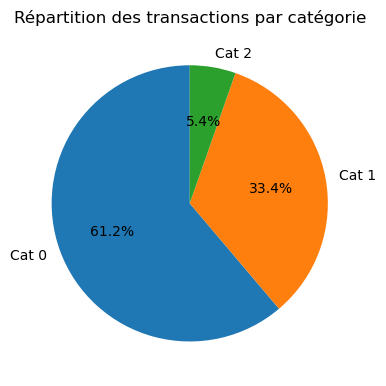

In [62]:
categ = ['Cat 0', 'Cat 1', 'Cat 2']
pie_categ = [len_transac_0, len_transac_1, len_transac_2]
fig = plt.figure(figsize=(4, 4))
plt.pie(pie_categ, labels=categ, autopct='%1.1f%%', startangle=90)
plt.title("Répartition des transactions par catégorie")
plt.show()

<h2 style="font-size:19px;color:blue"> Chiffre d'affaire par catégorie </h2>

In [63]:
CA_categ = transac_prod_cust.groupby('categ').agg({'price': 'sum'}).reset_index()
CA_categ = CA_categ.rename(columns={'price': 'CA'})
CA_categ['% du CA'] = round(CA_categ['CA'] / sum(CA_categ['CA']) *100, 2)
print(CA_categ)

   categ          CA  % du CA
0      0  4421938.76    37.30
1      1  4653722.69    39.25
2      2  2780275.02    23.45


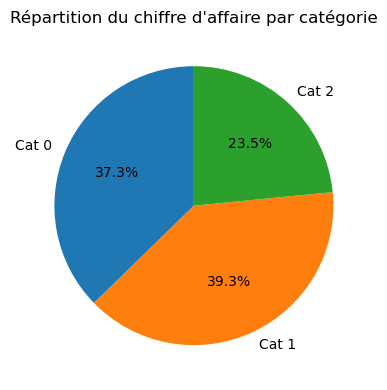

In [64]:
lab_CA_categ = ['Cat 0', 'Cat 1', 'Cat 2']
pie_CA_categ = CA_categ['CA']
fig = plt.figure(figsize=(4, 4))
plt.pie(pie_CA_categ, labels=lab_CA_categ, autopct='%1.1f%%', startangle=90)
plt.title("Répartition du chiffre d'affaire par catégorie")
plt.show()

<h2 style="font-size:19px;color:blue"> Chiffre d'affaire par période </h2>

In [65]:
CA_mois = transac_prod_cust.groupby(pd.Grouper(key='date', freq='M')).agg({'price': 'sum'}).reset_index() # Groupe par date et fréquence mensuelle
CA_mois = CA_mois.rename(columns={'date': 'période', 'price': 'CA'})
CA_mois['% du CA'] = round(CA_mois['CA']/sum(CA_mois['CA'])*100, 2) # Création d'une colonne '% du CA'
CA_mois['période'] = CA_mois['période'].dt.strftime('%Y-%m') # Converti en format de date plus lisible pour les graphique
print(CA_mois)

    période         CA  % du CA
0   2021-03  482530.52     4.07
1   2021-04  476249.16     4.02
2   2021-05  493023.39     4.16
3   2021-06  484158.49     4.08
4   2021-07  482875.36     4.07
5   2021-08  482374.70     4.07
6   2021-09  507360.56     4.28
7   2021-10  320868.67     2.71
8   2021-11  516267.63     4.35
9   2021-12  525987.21     4.44
10  2022-01  525388.94     4.43
11  2022-02  535681.39     4.52
12  2022-03  515566.42     4.35
13  2022-04  493138.80     4.16
14  2022-05  517292.44     4.36
15  2022-06  496086.05     4.18
16  2022-07  510903.00     4.31
17  2022-08  506547.19     4.27
18  2022-09  494204.44     4.17
19  2022-10  508017.67     4.28
20  2022-11  496774.83     4.19
21  2022-12  510279.44     4.30
22  2023-01  517610.48     4.37
23  2023-02  456749.69     3.85


##### Chiffre d'affaire fréquence journalière

In [66]:
CA_j = transac_prod_cust.groupby(pd.Grouper(key='date', freq='D')).agg({'price': 'sum'}).reset_index() # Groupe par date et fréquence journalière
CA_j = CA_j.rename(columns={'date': 'période', 'price': 'CA'})
CA_j['% du CA'] = round(CA_j['CA']/sum(CA_j['CA'])*100, 2) # Création d'une colonne '% du CA'
CA_j['période'] = CA_j['période'].dt.strftime('%Y-%m-%d') # Converti en format de date plus lisible pour les graphique
print(CA_j)

        période        CA  % du CA
0    2021-03-01  16575.21     0.14
1    2021-03-02  15496.44     0.13
2    2021-03-03  15198.69     0.13
3    2021-03-04  15196.07     0.13
4    2021-03-05  17471.37     0.15
..          ...       ...      ...
725  2023-02-24  15207.89     0.13
726  2023-02-25  15761.25     0.13
727  2023-02-26  16304.72     0.14
728  2023-02-27  19170.81     0.16
729  2023-02-28  18105.15     0.15

[730 rows x 3 columns]


##### Evolution du chiffre d'affaire et moyenne mobile hebdomadaire

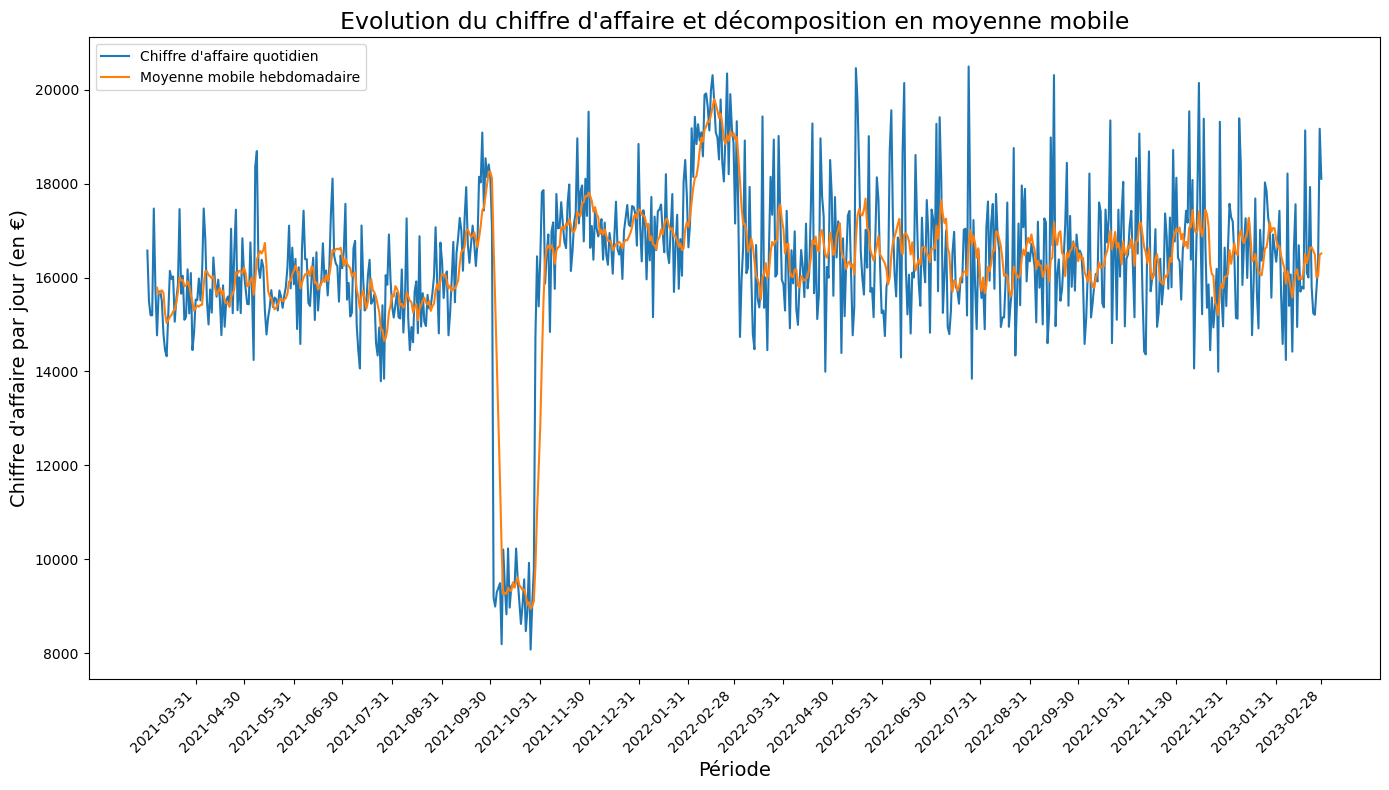

In [67]:
CA_j['période'] = pd.to_datetime(CA_j['période']) # Conversion en date

# Création du graphique et labels
plt.plot(CA_j['période'], CA_j['CA'], label="Chiffre d'affaire quotidien")

# Ajout de la moyenne mobile sur 7 jours
CA_j['MA'] = CA_j['CA'].rolling(7).mean()
plt.plot(CA_j['période'], CA_j['MA'], label="Moyenne mobile hebdomadaire")

plt.title("Evolution du chiffre d'affaire et décomposition en moyenne mobile", fontsize = 17)
plt.xlabel('Période', fontsize = 14)
plt.ylabel("Chiffre d'affaire par jour (en €)", fontsize = 14)

# Date absisses fréquence mensuelle
dates = pd.date_range(start=CA_j['période'].iloc[0], end=CA_j['période'].iloc[-1], freq='M')
plt.xticks(dates, dates.strftime('%Y-%m-%d'), rotation=45, ha='right')

plt.legend()
plt.show()

- Nous observons de fortes variations du chiffre d'affaire quotidien
- La moyenne mobile sur 7 jours correspond à la moyenne quotidienne du CA
- La très forte chute du chiffre d'affaire sur le mois d'octobre 2021 sera élucidée dans la suite de l'analyse.

<h2 style="font-size:19px;color:blue"> Nombre de transactions par période </h2>

In [68]:
nb_transac_mois = transac_prod_cust.groupby(pd.Grouper(key='date', freq='M')).agg({'price': 'count'}).reset_index()
nb_transac_mois = nb_transac_mois.rename(columns={'price': 'transaction', 'date': 'période'})
nb_transac_mois['période'] = nb_transac_mois['période'].dt.strftime('%Y-%m') # Converti en format de date plus lisible pour les graphique
nb_transac_mois['% transac totales'] = round(nb_transac_mois['transaction']/sum(nb_transac_mois['transaction'])*100, 2)
print(nb_transac_mois)

    période  transaction  % transac totales
0   2021-03        28610               4.21
1   2021-04        28457               4.19
2   2021-05        28293               4.16
3   2021-06        26857               3.95
4   2021-07        24742               3.64
5   2021-08        25659               3.78
6   2021-09        33326               4.91
7   2021-10        21606               3.18
8   2021-11        28321               4.17
9   2021-12        32464               4.78
10  2022-01        29348               4.32
11  2022-02        29605               4.36
12  2022-03        29707               4.37
13  2022-04        27616               4.07
14  2022-05        29991               4.41
15  2022-06        28511               4.20
16  2022-07        28682               4.22
17  2022-08        28552               4.20
18  2022-09        28315               4.17
19  2022-10        28974               4.27
20  2022-11        28574               4.21
21  2022-12        28625        

In [69]:
transac_j = transac_prod_cust.groupby(pd.Grouper(key='date', freq='D')).agg({'price': 'count'}).reset_index()
transac_j = transac_j.rename(columns={'price': 'transaction', 'date': 'période'})
transac_j['période'] = transac_j['période'].dt.strftime('%Y-%m-%d') # Converti en format de date plus lisible pour les graphiques
transac_j['% transac totales'] = round(transac_j['transaction']/sum(transac_j['transaction'])*100, 2)
print(transac_j)

        période  transaction  % transac totales
0    2021-03-01          963               0.14
1    2021-03-02          940               0.14
2    2021-03-03          911               0.13
3    2021-03-04          903               0.13
4    2021-03-05          943               0.14
..          ...          ...                ...
725  2023-02-24          894               0.13
726  2023-02-25          905               0.13
727  2023-02-26          890               0.13
728  2023-02-27         1110               0.16
729  2023-02-28          961               0.14

[730 rows x 3 columns]


##### Evolution des ventes et moyenne mobile hebdomadaire

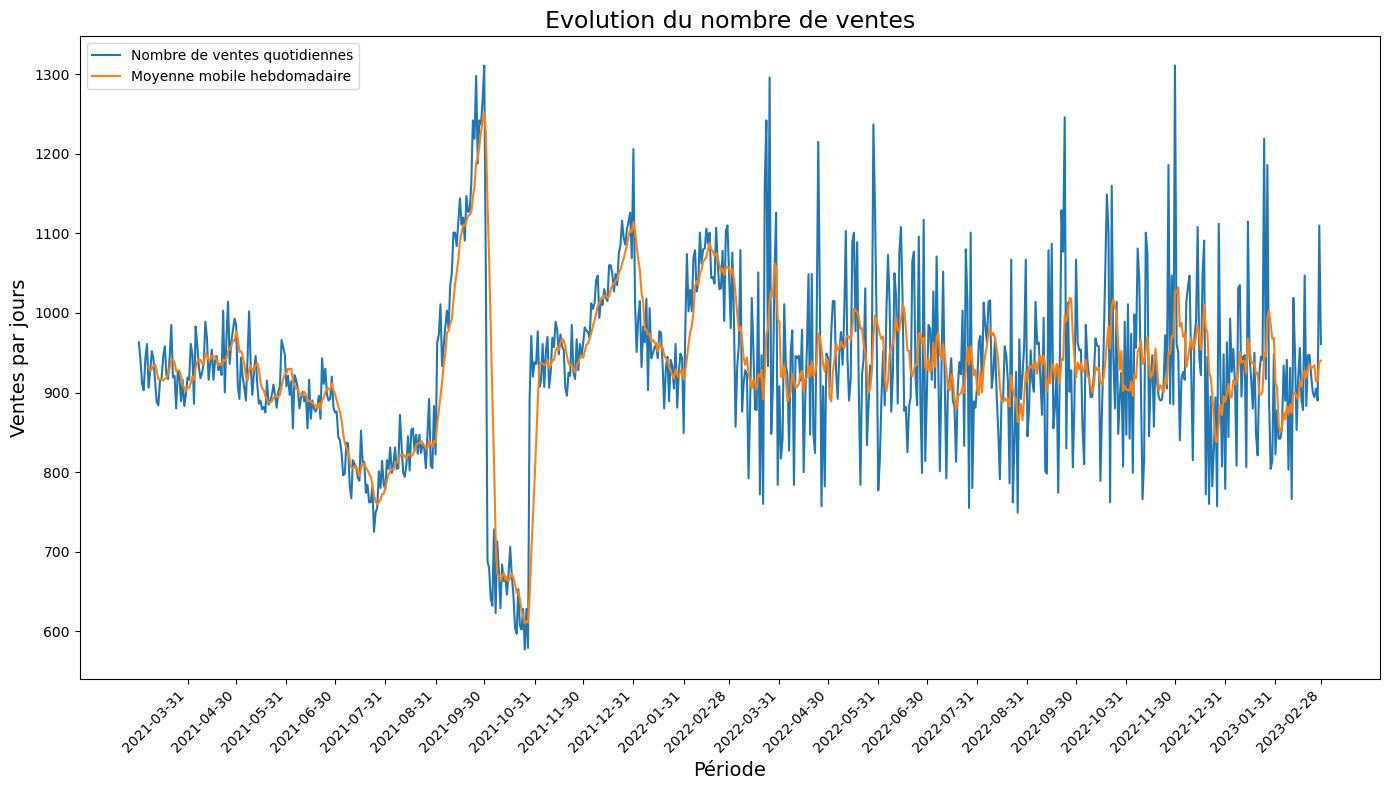

In [70]:
transac_j['période'] = pd.to_datetime(transac_j['période']) # Conversion en date

# Création du graphique et labels
plt.plot(transac_j['période'], transac_j['transaction'], label="Nombre de ventes quotidiennes")

# Ajout de la moyenne mobile sur 7 jours
transac_j['MA'] = transac_j['transaction'].rolling(7).mean()
plt.plot(transac_j['période'], transac_j['MA'], label="Moyenne mobile hebdomadaire")

plt.title("Evolution du nombre de ventes", fontsize = 17)
plt.xlabel('Période', fontsize = 14)
plt.ylabel("Ventes par jours", fontsize = 14)

# Date absisses fréquence mensuelle
dates_transac = pd.date_range(start=transac_j['période'].iloc[0], end=transac_j['période'].iloc[-1], freq='M')
plt.xticks(dates_transac, dates_transac.strftime('%Y-%m-%d'), rotation=45, ha='right')

plt.legend()
plt.show()

- Variabilité du nombre de ventes dans des proportions similaires à celle du chiffre d'affaire
- Forte augmentation en septembre 2021
- Pas de saisonnalité particulière
- Baisse significative du nombre de transaction du mois d'octobre 2021 proportionnelle à la baisse du chiffre d'affaire.
- Nous allons désormais explorer ce mois d'octobre afin de repérer si cette baisse est due à une anomalie, ou si elle reflète une baisse d'activité. 

<h2 style="font-size:19px;color:blue"> Exploration du mois d'octobre 2021 </h2>

In [71]:
nb_transac_oct = transac_prod_cust.groupby(pd.Grouper(key='date', freq='D')).agg({'price': 'count'}).reset_index()
nb_transac_oct = nb_transac_oct.rename(columns={'price': 'transaction', 'date': 'jour'})
nb_transac_oct = nb_transac_oct.query('jour.dt.month == 10 and jour.dt.year == 2021')
nb_transac_oct

,jour,transaction
214,2021-10-01,1045
215,2021-10-02,689
216,2021-10-03,679
217,2021-10-04,641
218,2021-10-05,632
219,2021-10-06,728
220,2021-10-07,623
221,2021-10-08,713
222,2021-10-09,675
223,2021-10-10,629


- Nous observons qu'aucun jour de collecte de données est manquant durant le mois d'octobre 2021. 

##### Exploration du nombre de transactions par catégories

In [72]:
transac_oct = transac_prod_cust.query('date.dt.month == 10 and date.dt.year == 2021')
len_transac_oct_0 = len(transac_oct[(transac_oct['categ'] == 0)])
len_transac_oct_1 = len(transac_oct[(transac_oct['categ'] == 1)])
len_transac_oct_2 = len(transac_oct[(transac_oct['categ'] == 2)])

print("Il y a", len_transac_oct_0, "transactions de catégorie 0 en Octobre 2021")
print("Il y a", len_transac_oct_1, "transactions de catégorie 1 en Octobre 2021")
print("Il y a", len_transac_oct_2, "transactions de catégorie 2 en Octobre 2021")

Il y a 18769 transactions de catégorie 0 en Octobre 2021
Il y a 1666 transactions de catégorie 1 en Octobre 2021
Il y a 1171 transactions de catégorie 2 en Octobre 2021


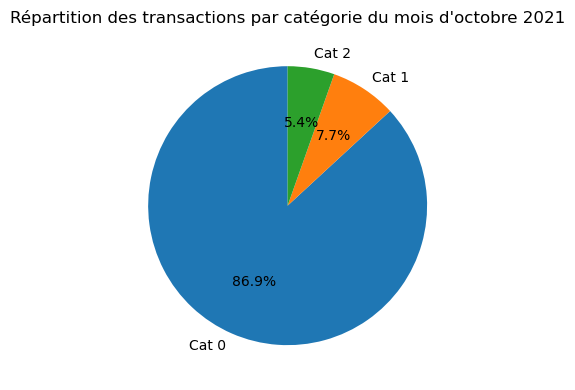

In [73]:
categ_oct = ['Cat 0', 'Cat 1', 'Cat 2']
pie_cat_oct = [len_transac_oct_0, len_transac_oct_1, len_transac_oct_2]
fig = plt.figure(figsize=(4, 4))
plt.pie(pie_cat_oct, labels=categ_oct, autopct='%1.1f%%', startangle=90)
plt.title("Répartition des transactions par catégorie du mois d'octobre 2021")
plt.show()

- Par rapport au nombre de transactions moyennes par catégories (cf 3.2 : Nombre de transactions par catégorie), la catégorie 1 semble anormalement sous-représentée durant le mois d'octobre 2021. 

##### Listing des transactions par jours et par catégories

In [74]:
nb_transac_oct_categ = transac_prod_cust.groupby(['categ', pd.Grouper(key='date', freq='D')]).agg({'price': 'count'}).reset_index()
nb_transac_oct_categ = nb_transac_oct_categ.rename(columns={'price': 'transaction', 'date': 'jour'})
nb_transac_oct_categ = nb_transac_oct_categ.query('jour.dt.month == 10 and jour.dt.year == 2021')

In [75]:
nb_transac_oct_categ.head(50)

,categ,jour,transaction
214,0,2021-10-01,663
215,0,2021-10-02,661
216,0,2021-10-03,648
217,0,2021-10-04,603
218,0,2021-10-05,594
219,0,2021-10-06,702
220,0,2021-10-07,597
221,0,2021-10-08,669
222,0,2021-10-09,640
223,0,2021-10-10,600


In [76]:
jours_transac_oct_cat_0 = len(nb_transac_oct_categ.query('categ == 0'))
jours_transac_oct_cat_1 = len(nb_transac_oct_categ.query('categ == 1'))
jours_transac_oct_cat_2 = len(nb_transac_oct_categ.query('categ == 2'))

print("Il y a", jours_transac_oct_cat_0 , " Jours de transactions de catégorie 0 en Octobre 2021")
print("Il y a", jours_transac_oct_cat_1, " Jours de transactions de catégorie 1 en Octobre 2021")
print("Il y a", jours_transac_oct_cat_2, " Jours de transactions de catégorie 2 en Octobre 2021")


Il y a 31  Jours de transactions de catégorie 0 en Octobre 2021
Il y a 5  Jours de transactions de catégorie 1 en Octobre 2021
Il y a 31  Jours de transactions de catégorie 2 en Octobre 2021


- Nous remarquons des pertes de données concernant les ventes des biens de catégorie 1 sur la période du 02-10 au 27-10 inclus.
- Cette perte de données se répercute sur le chiffre d'affaire, et explique la baisse significative du CA sur le mois d'octobre 2021

<h2 style="font-size:19px;color:blue"> Chiffre d'affaire par client </h2>

In [77]:
CA_client = transac_prod_cust.groupby('client_id').agg({'price': 'sum'}).reset_index()
CA_client = CA_client.rename(columns={'price': 'CA'})
CA_client['% du CA'] = round(CA_client['CA'] / sum(CA_client['CA']) *100, 2)
CA_client = CA_client.sort_values(by='CA', ascending=False)
CA_client.head(20)

,client_id,CA,% du CA
677,c_1609,324033.35,2.73
4388,c_4958,289760.34,2.44
6337,c_6714,153658.86,1.30
2724,c_3454,113667.90,0.96
2513,c_3263,5276.87,0.04
634,c_1570,5271.62,0.04
2108,c_2899,5214.05,0.04
1268,c_2140,5208.82,0.04
7006,c_7319,5155.77,0.04
7791,c_8026,5092.57,0.04


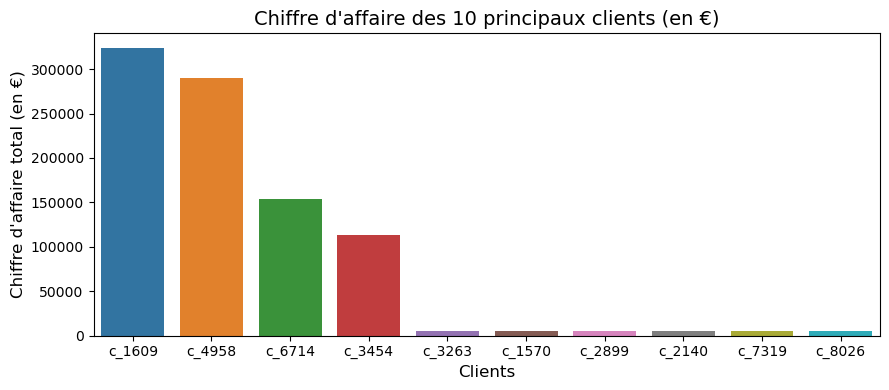

In [78]:
CA_client_10 = CA_client.head(10)

plt.figure(figsize=(9,4))
sns.barplot(data=CA_client_10, x = 'client_id', y = 'CA')

plt.title("Chiffre d'affaire des 10 principaux clients (en €)", fontsize=14)
plt.ylabel("Chiffre d'affaire total (en €)", fontsize=12)
plt.xlabel("Clients", fontsize=12)
plt.show()

- Les 4 principaux clients contribuent à hauteur de 7,43% du chiffre du chiffre d'affaire total, et sont assurément des sociétés clientes. 

<h2 style="font-size:19px;color:blue"> Produits les plus et moins vendus </h2>

##### Top 10 produits en terme de chiffre d'affaire

In [79]:
CA_prod = transac_prod_cust.groupby('id_prod').agg({'price': 'sum'}).reset_index()
CA_prod = CA_prod.rename(columns={'price': 'CA'})
CA_prod['% du CA'] = round(CA_prod['CA'] / sum(CA_client['CA']) *100, 3)
CA_prod = CA_prod.sort_values(by='CA', ascending=False)
CA_prod

,id_prod,CA,% du CA
3097,2_159,94893.50,0.800
3071,2_135,69334.95,0.585
3046,2_112,65407.76,0.552
3035,2_102,60736.78,0.512
3153,2_209,56971.86,0.481
...,...,...,...
665,0_1601,1.99,0.000
2080,0_807,1.99,0.000
719,0_1653,1.98,0.000
313,0_1284,1.38,0.000


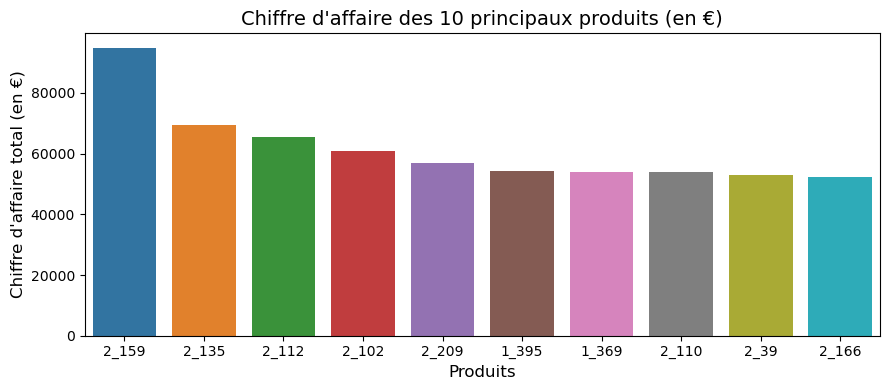

In [80]:
CA_prod_10 = CA_prod.head(10)

plt.figure(figsize=(9,4))

sns.barplot(data=CA_prod_10, x = 'id_prod', y = 'CA')
plt.title("Chiffre d'affaire des 10 principaux produits (en €)", fontsize=14)
plt.xlabel("Produits", fontsize=12)
plt.ylabel("Chiffre d'affaire total (en €)", fontsize=12)
plt.show()

##### Top 10 produits en terme de transactions

In [81]:
transac_top = transac_prod_cust.groupby('id_prod').agg({'price': 'count'}).reset_index()
transac_top = transac_top.rename(columns={'price': 'transactions'})
transac_top = transac_top.sort_values(by='transactions', ascending=False)
transac_top

,id_prod,transactions
2592,1_369,2252
2645,1_417,2189
2642,1_414,2180
2734,1_498,2128
2654,1_425,2096
...,...,...
313,0_1284,1
1793,0_549,1
549,0_1498,1
1785,0_541,1


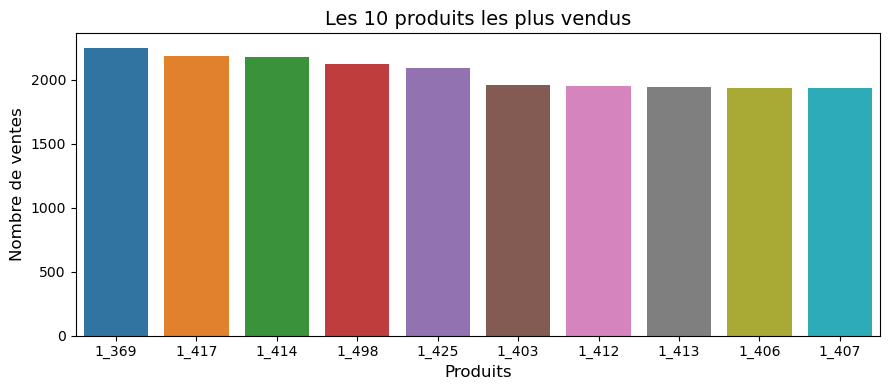

In [82]:
transac_top_10 = transac_top.head(10)

plt.figure(figsize=(9,4))

sns.barplot(data=transac_top_10, x = 'id_prod', y = 'transactions')
plt.title("Les 10 produits les plus vendus", fontsize=14)
plt.xlabel("Produits", fontsize=12)
plt.ylabel("Nombre de ventes", fontsize=12)
plt.show()

##### Flop 10 produits en terme de chiffre d'affaire

In [83]:
Flop_prod = CA_prod.sort_values(by='CA', ascending=True)
Flop_prod

,id_prod,CA,% du CA
595,0_1539,0.99,0.000
313,0_1284,1.38,0.000
719,0_1653,1.98,0.000
1785,0_541,1.99,0.000
2080,0_807,1.99,0.000
...,...,...,...
3153,2_209,56971.86,0.481
3035,2_102,60736.78,0.512
3046,2_112,65407.76,0.552
3071,2_135,69334.95,0.585


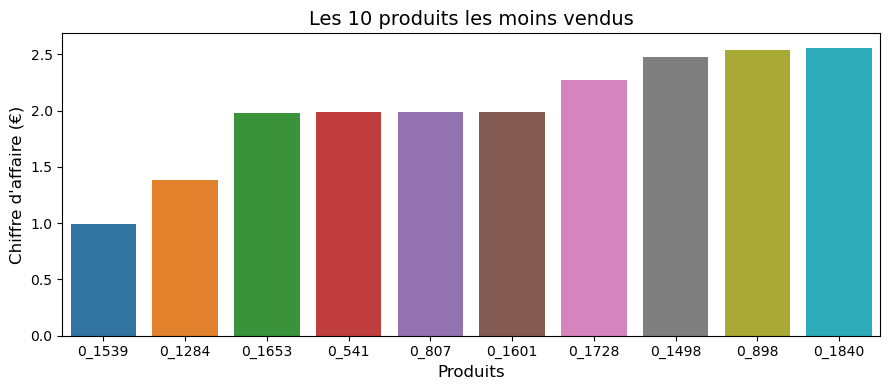

In [84]:
Flop_prod_10 = Flop_prod.head(10)
plt.figure(figsize=(9,4))
sns.barplot(data=Flop_prod_10, x = 'id_prod', y = 'CA')
plt.title("Les 10 produits les moins vendus", fontsize=14)
plt.xlabel("Produits", fontsize=12)
plt.ylabel("Chiffre d'affaire (€)", fontsize=12)
plt.show()

<h2 style="font-size:19px;color:blue"> Courbe de lorenz </h2>

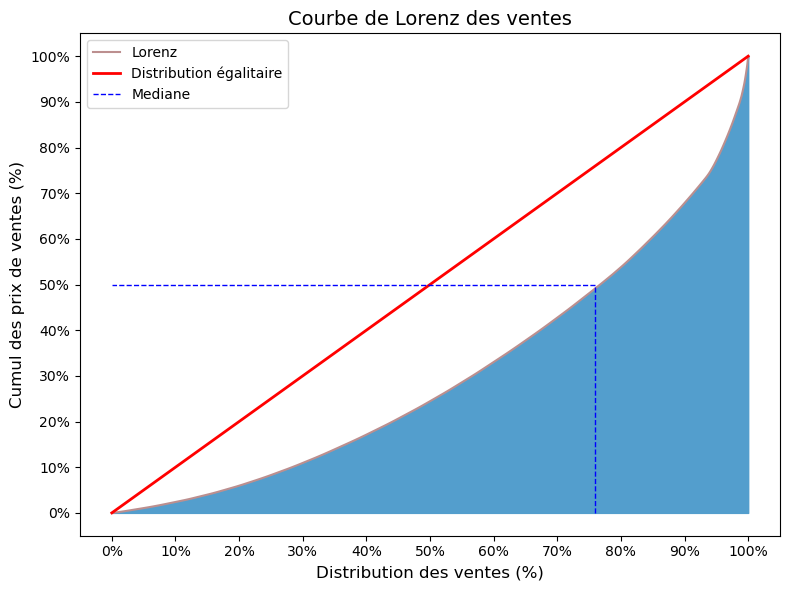

In [85]:
# Calcul de la courbe de Lorenz
lorenz_price = np.cumsum(np.sort(transac_prod_cust['price'])) / transac_prod_cust['price'].sum()
plt.figure(figsize=(8,6))
plt.plot(np.linspace(0,1,len(lorenz_price)), lorenz_price, drawstyle='steps-post', color='rosybrown', label='Lorenz')

# Remplissage en bleue 
plt.fill_between(np.linspace(0,1,len(lorenz_price)), lorenz_price, color='#539ecd')

# Ligne égalitaire (rouge)
plt.plot([0, 1], [0, 1], 'r-', lw=2, label='Distribution égalitaire')

# Tracé de la médiane
plt.vlines(x=.76, ymin=0, ymax=.5, color='blue', linestyle='--', linewidth=1, label='Mediane')
plt.hlines(xmin=.76, xmax=0, y=.5, color='blue', linestyle='--', linewidth=1)

# Axes en pourcentages (%)
plt.xticks(np.arange(0, 1.1, 0.1), ['{}%'.format(int(x*100)) for x in np.arange(0, 1.1, 0.1)])
plt.yticks(np.arange(0, 1.1, 0.1), ['{}%'.format(int(y*100)) for y in np.arange(0, 1.1, 0.1)])

plt.title('Courbe de Lorenz des ventes', fontsize = 14)
plt.xlabel("Distribution des ventes (%)", fontsize = 12)
plt.ylabel("Cumul des prix de ventes (%)", fontsize = 12)
plt.legend(loc="best")

plt.show()

<h1 style="font-size:22px;color:red"> Informations clients </h1>

<h2 style="font-size:19px;color:blue"> Distribution des âges des clients </h2>

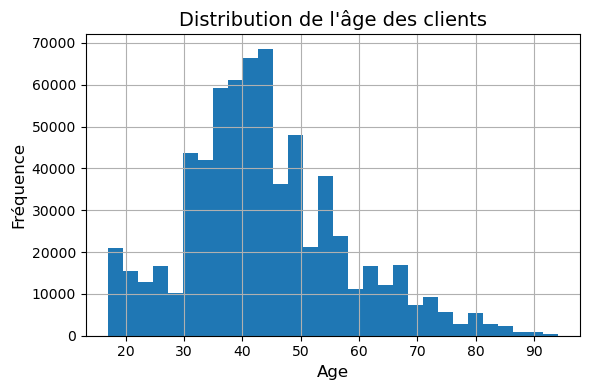

In [86]:
distrib_age = transac_prod_cust.copy()
distrib_age['date_année'] = distrib_age['date'].dt.strftime('%Y').astype(int)  # Convertir en entier
distrib_age['birth'] = distrib_age['birth'].astype(int)  # Convertir en entier si nécessaire
distrib_age['age'] = distrib_age['date_année'] - distrib_age['birth']

plt.figure(figsize=(6,4))
distrib_age['age'].hist(bins=30)
plt.xlabel('Age', fontsize = 12)
plt.ylabel('Fréquence', fontsize = 12)
plt.title("Distribution de l'âge des clients", fontsize = 14)
plt.show()

<h2 style="font-size:19px;color:blue"> Âge et catégories de livres achetés </h2>

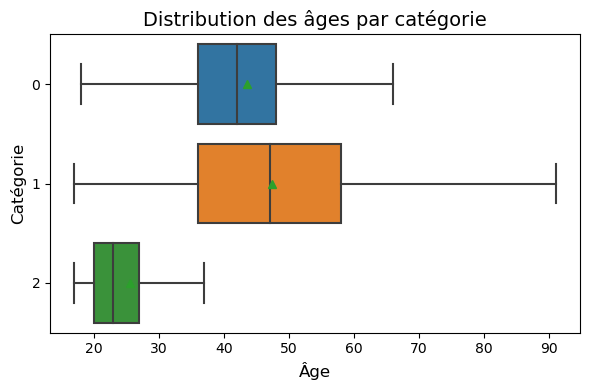

In [87]:
plt.figure(figsize=(6,4))
sns.boxplot(data=distrib_age, x='age', y='categ', orient='h', showfliers=False, showmeans=True)

plt.title('Distribution des âges par catégorie', fontsize = 14)
plt.xlabel('Âge', fontsize = 12)
plt.ylabel('Catégorie', fontsize = 12)

plt.show()

In [88]:
round(distrib_age.groupby('categ').mean()['age'], 2) # Moyenne des âges par catégorie

categ
0    43.55
1    47.35
2    25.63
Name: age, dtype: float64

<h2 style="font-size:19px;color:blue"> Genre des clients </h2>

##### Chiffre d'affaire en fonction du genre

In [89]:
CA_genre = transac_prod_cust.groupby(by='sex').sum()
CA_genre = CA_genre.rename(columns={'price': 'CA'})
CA_genre = CA_genre.drop(['categ', 'birth'], axis=1)
CA_genre['%'] = round((CA_genre['CA'] / CA_tot)*100, 2)
print(CA_genre)

             CA      %
sex                   
f    5860851.96  49.43
m    5995084.51  50.57


##### Nombre de transactions en fonction du genre

In [90]:
transac_genre = transac_prod_cust.groupby(by='sex').count()
transac_genre = transac_genre.rename(columns={'price': 'achats'})
transac_genre = transac_genre.drop(['categ', 'birth', 'id_prod', 'date', 'session_id', 'client_id'], axis=1)
transac_genre['%'] = (transac_genre['achats'] / nb_transac)*100
print(transac_genre)

     achats          %
sex                   
f    338402  49.813935
m    340930  50.186065


<h2 style="font-size:19px;color:blue"> Genre et catégories de livres achetés </h2>

In [91]:
genre_categ = transac_prod_cust.groupby(['categ', 'sex']).agg({'price': ['count', 'sum']}).reset_index()  # Réinitialiser les index pour obtenir un dataframe plat
genre_categ.columns = ['categ', 'sex', 'transac', 'CA']
print(genre_categ)

   categ sex  transac          CA
0      0   f   206220  2191181.90
1      0   m   209460  2230756.86
2      1   f   114899  2358417.02
3      1   m   112270  2295305.67
4      2   f    17283  1311253.04
5      2   m    19200  1469021.98


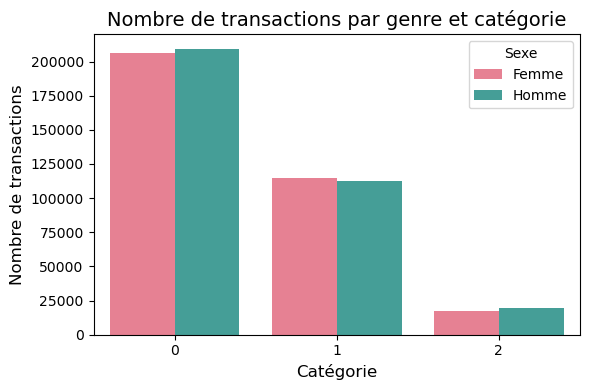

In [92]:
plt.figure(figsize=(6,4))
sns.barplot(data=genre_categ, x='categ', y='transac', hue='sex', palette="husl")

plt.title("Nombre de transactions par genre et catégorie", fontsize=14)
plt.xlabel("Catégorie", fontsize=12)
plt.ylabel("Nombre de transactions", fontsize=12)

new_labels = ['Femme', 'Homme']
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles = handles, title='Sexe', labels=new_labels)

plt.show()

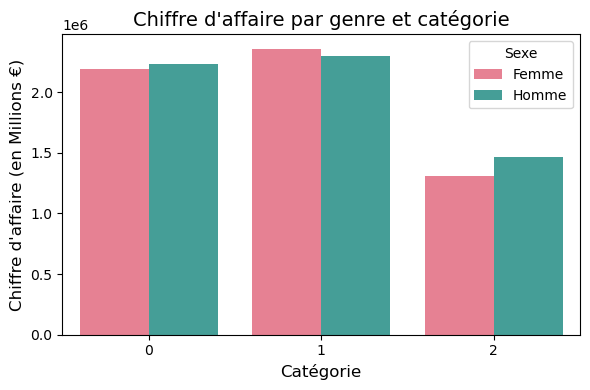

In [93]:
plt.figure(figsize=(6,4))
sns.barplot(data=genre_categ, x='categ', y='CA', hue='sex', palette="husl")

plt.title("Chiffre d'affaire par genre et catégorie", fontsize=14)
plt.xlabel("Catégorie", fontsize=12)
plt.ylabel("Chiffre d'affaire (en Millions €)", fontsize=12)

new_labels = ['Femme', 'Homme']
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles = handles, title='Sexe', labels=new_labels)

plt.show()

<h1 style="font-size:22px;color:red"> Tests Statistiques </h1>

<h2 style="font-size:19px;color:blue"> Quel est le lien entre le genre et la catégorie de livre achetée ?  </h2>

##### Test du Chi² : 2 variables qualitatives

- Hypothèse nulle H0 : Les variables sont indépendantes : il n'y a pas d'association statistique entre le genre et la catégorie de livre achetée
- Hypothèse alternative H1 : Les deux variables ne sont pas indépendantes : il y a une association statistique entre le genre d'un individu et la catégorie de livre acheté. 

In [94]:
tableau_contin = pd.crosstab(transac_prod_cust['sex'], transac_prod_cust['categ'])
tableau_contin

categ,0,1,2
sex,,,
f,206220,114899,17283
m,209460,112270,19200


In [95]:
stat, p_value, dof, expected = chi2_contingency(tableau_contin)
print("Score du Chi² :", stat)
print("P-val :", p_value)
print("Degrés de liberté :", dof)
print("Fréquences attendues :", expected)

Score du Chi² : 147.00253568681114
P-val : 1.1989607410166063e-32
Degrés de liberté : 2
Fréquences attendues : [[207066.56444861 113161.81769444  18173.61785695]
 [208613.43555139 114007.18230556  18309.38214305]]


- La p-val de 1.199e-32 permet de conclure à une très forte association statistique entre le genre d'un individu et les catégories de livres qu'il est susceptible d'acheter. 
- L'hypothèse H1 est acceptée : les variables sont dépendantes.

<h2 style="font-size:19px;color:blue"> Tests statistiques en fonction de l'âge : préparation des données </h2>

##### Regroupement du chiffre d'affaire par âge

In [96]:
distrib_age_grouped = distrib_age.groupby(by='age', as_index=False).sum()
distrib_age_grouped['% CA'] = round((distrib_age_grouped['price'] / sum(distrib_age_grouped['price']))*100, 2)
distrib_age_grouped = distrib_age_grouped[['age', 'price', '% CA']]
distrib_age_grouped

,age,price,% CA
0,17,241265.83,2.03
1,18,384592.43,3.24
2,19,221910.09,1.87
3,20,177125.26,1.49
4,21,172101.74,1.45
...,...,...,...
73,90,4114.03,0.03
74,91,3455.02,0.03
75,92,3309.62,0.03
76,93,2115.62,0.02


##### Regroupement des effectifs par âge

In [97]:
distrib_age_count = distrib_age.groupby(by='age', as_index=False).count()
distrib_age_count = distrib_age_count[['sex', 'age']]
distrib_age_count.rename(columns={'sex': 'nombre'}, inplace=True)
distrib_age_count

,nombre,age
0,5935,17
1,9636,18
2,5409,19
3,4432,20
4,4306,21
...,...,...
73,243,90
74,210,91
75,196,92
76,129,93


##### Merge des tables distrib_age_grouped et distrib_age_count afin d'obtenir un dataframe exploitable

In [98]:
distrib_age_grouped = pd.merge(distrib_age_grouped, distrib_age_count, how="left")
distrib_age_grouped.rename(columns={'price': 'somme ventes'}, inplace=True)
distrib_age_grouped['panier moyen'] = round(distrib_age_grouped['somme ventes'] / distrib_age_grouped['nombre'], 2) # Panier moyen
distrib_age_grouped

,age,somme ventes,% CA,nombre,panier moyen
0,17,241265.83,2.03,5935,40.65
1,18,384592.43,3.24,9636,39.91
2,19,221910.09,1.87,5409,41.03
3,20,177125.26,1.49,4432,39.97
4,21,172101.74,1.45,4306,39.97
...,...,...,...,...,...
73,90,4114.03,0.03,243,16.93
74,91,3455.02,0.03,210,16.45
75,92,3309.62,0.03,196,16.89
76,93,2115.62,0.02,129,16.40


- Précédement, nous avons vu que la distribution des âges n'était pas uniforme. Nous préférons diviser les âges dans des intervalles.

In [99]:
cut_age = [17, 25, 35, 45, 55, 65, 100]
interv_age = pd.cut(distrib_age_grouped['age'], bins=cut_age)
interv_age = distrib_age_grouped.groupby(interv_age).agg({'somme ventes': 'sum', '% CA': 'sum', 'nombre': 'sum', 'panier moyen': 'mean'})
interv_age

,somme ventes,% CA,nombre,panier moyen
age,,,,
"(17, 25]",2039045.72,17.19,48738,41.653750
"(25, 35]",2389918.86,20.15,129228,24.974000
"(35, 45]",3078795.56,25.97,233320,13.209000
"(45, 55]",2123224.04,17.92,143859,15.065000
"(55, 65]",1071889.52,9.04,63856,16.777000
"(65, 100]",911796.94,7.70,54396,16.816552


<h2 style="font-size:19px;color:blue"> Quel est le lien entre l'âge d'un client et son panier moyen ? </h2>

##### Quel test utiliser ? 
- L'âge et la taille du panier moyen sont des variables quantitatives continues
- Le lien entre l'âge d'un client et son panier moyen suggère de déterminer la corrélation entre les deux. Déterminer l'influence de l'âge sur la taille moyenne du panier et vice versa.

##### Les différents test de corrélations
1. Test paramétrique de Pearson pour les données suivant une distribution normale
2. Test non paramétrique de Spearman pour les données ne suivant pas une distribution normale

La distribution ne suit pas une loi normale (p = 0.000)


Text(0.5, 1.0, "QQ-plot de l'âge")

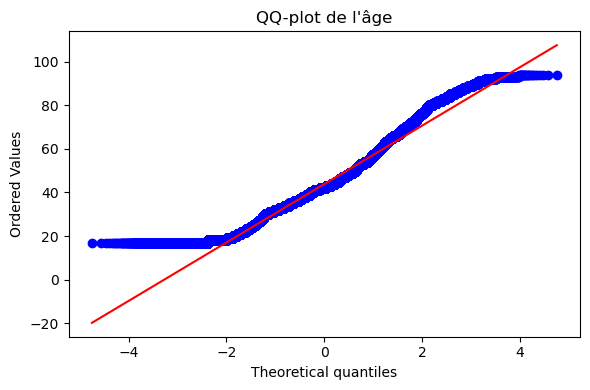

In [100]:
stat, p = shapiro(distrib_age['age'])
alpha = 0.05
if p > alpha:
    print('La distribution est normale (p = %.3f)' % p)
else:
    print('La distribution ne suit pas une loi normale (p = %.3f)' % p)

plt.figure(figsize=(6,4))
stats.probplot(distrib_age['age'], dist="norm", plot=plt)
plt.title("QQ-plot de l'âge")

- Le test de Shapiro-wilk suivi du graphique représentatif suggère que la distribution ne suit pas une loi normale. Graphiquement, les points s'écartent de la droite diagonale rouge.
- Pour éviter divers biais et résultats incorrects, il est recommandé d'utiliser un test non paramétrique.

##### Test de Spearman : Relation entre l'âge et le montant moyen du panier

Le Coefficient de Spearman est un test non paramétrique qui mesure la force et la direction de la corrélation entre deux variables.
- Il varie entre -1 et +1.
- -1 indique une corrélation négative parfaite, et +1 indique une corrélation positive parfaite.   
- 0 = absence de corrélation.
- 0.5 et + indique généralement une corrélation forte.
- 0.3 et - indique une corrélation faible.

In [101]:
age_spear = interv_age.index.categories.mid # Convertir chaque intervalle en sa valeur moyenne
panier_moyen_spear = stats.rankdata(interv_age['panier moyen'])
corr, p_value = stats.spearmanr(age_spear, panier_moyen_spear)

print("Coefficient de corrélation de Spearman :", corr)
print("Valeur p associée :", p_value)

Coefficient de corrélation de Spearman : -0.4285714285714286
Valeur p associée : 0.3965014577259474


- D'après le test de Pearson, il existe une corrélation négative de force moyenne entre l'âge et la taille moyenne du panier.
- Autrement dit : plus l'âge augmente, plus la taile du panier moyen diminue et vice versa
- Néanmoins, la p-value indique que la corrélation observée n'est pas statistiquement significative (p-val = 0.397), par rapport aux marges d'erreur scientifiques habituelles de 5% (p-val < 0.05).

Text(0, 0.5, 'Total des ventes (en €)')

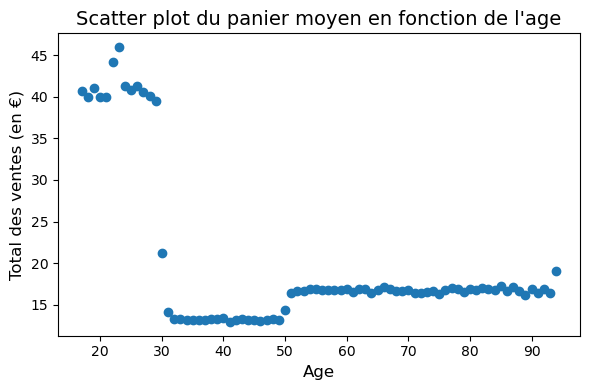

In [102]:
plt.figure(figsize=(6,4))
x=distrib_age_grouped['age']
y=distrib_age_grouped['panier moyen']

plt.scatter(x,y)
plt.title("Scatter plot du panier moyen en fonction de l'age", fontsize = 14)
plt.xlabel('Age', fontsize = 12)
plt.ylabel('Total des ventes (en €)', fontsize = 12)

- Graphiquement, nous observons une forte baisse de la taille du panier moyen entre la génération des 30 - 50 ans par rapport à la génération des 17 - 29 ans. Dans ce cas, la corrélation de Spearson serait négativement très forte, et la p-val associée serait potentiellement très faible.
- Néanmoins, on observe une hausse de la taille du panier moyen de la génération des 50 ans et plus, par rapport à la génération 30 - 50 ans. Cette hausse contribue certainement à réduire la valeur du coefficient de Spearman, et augmente la variabilité des données, rendant la relation statistiquement non significative (p-value élevée). 

<h2 style="font-size:19px;color:blue"> Quel est le lien entre l'âge d'un client et le montant total de ses achats ? </h2>

##### Test de Spearman : Relation entre l'âge et le total des ventes

In [103]:
panier_total_spear = interv_age['somme ventes']
corr, p_value = stats.spearmanr(age_spear, panier_total_spear)

print("Coefficient de corrélation de Spearman :", corr)
print("Valeur p associée :", p_value)

Coefficient de corrélation de Spearman : -0.6
Valeur p associée : 0.20799999999999982


- D'après le test de Spearman, il existe une forte corrélation négative entre l'âge et la somme totale du panier.
- Autrement dit : plus l'âge augmente, plus la somme totale du montant total des achats et vice versa
- La corrélation est plus forte, et statistiquement plus significative, par rapport à celle entre l'âge et le panier moyen.
- Néanmoins, la p-value n'est pas assez faible pour assurer la relation statistique (0.208 > 0.05).

Text(0, 0.5, 'Total des ventes (en €)')

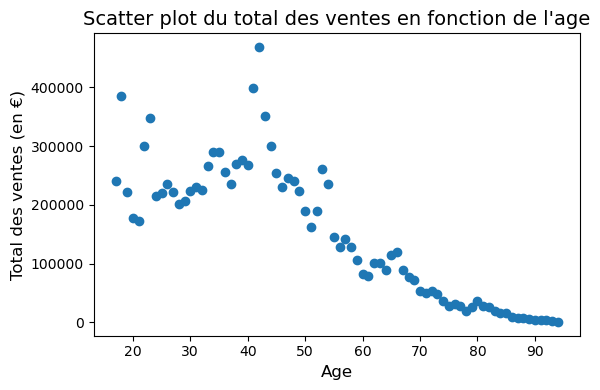

In [104]:
plt.figure(figsize=(6,4))
x=distrib_age_grouped['age']
y=distrib_age_grouped['somme ventes']

plt.scatter(x,y)
plt.title("Scatter plot du total des ventes en fonction de l'age", fontsize = 14)
plt.xlabel('Age', fontsize = 12)
plt.ylabel('Total des ventes (en €)', fontsize = 12)

- Graphiquement, nous observons une forte variabilité du total des ventes des 50 ans et moins.
- Pour les 50 ans et plus, ce total des ventes diminue à mesure que l'age augmente, et semble adopter une relation plus linéaire, avec de faibles variations. 

<h2 style="font-size:19px;color:blue"> Quel est le lien entre l'âge d'un client et sa fréquence d'achat ? </h2>

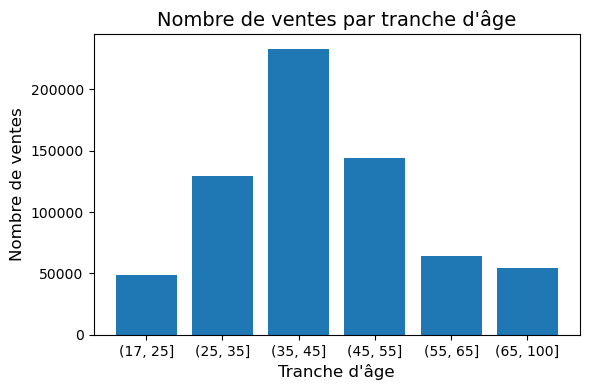

In [105]:
plt.figure(figsize=(6,4))
age_hist = interv_age.index.astype(str)
somme_ventes = interv_age['nombre']
plt.bar(age_hist, somme_ventes)

plt.xlabel("Tranche d'âge", fontsize = 12)
plt.ylabel('Nombre de ventes', fontsize = 12)
plt.title("Nombre de ventes par tranche d'âge", fontsize = 14)
plt.show()

##### Regroupement du nombre de sessions par clients

In [106]:
distrib_age_freq = distrib_age.groupby('client_id').agg({'price': 'sum', 'session_id': 'nunique', 'age': 'first', 'sex': 'first'})
distrib_age_freq = distrib_age_freq.rename(columns={'price': 'CA', 'session_id': 'nb_sessions', 'age': 'age', 'sex': 'sexe'})
distrib_age_freq = distrib_age_freq.sort_values(by='nb_sessions', ascending=False)
distrib_age_freq.head(20)

,CA,nb_sessions,age,sexe
client_id,,,,
c_1609,324033.35,10997,41,m
c_3454,113667.90,5573,52,m
c_4958,289760.34,3851,22,m
c_6714,153658.86,2620,54,f
c_8526,3975.06,165,56,f
c_1637,4698.87,164,33,f
c_669,4499.36,163,34,m
c_2265,3271.28,163,53,m
c_682,4102.18,161,48,f


Text(0, 0.5, 'Nombre achat')

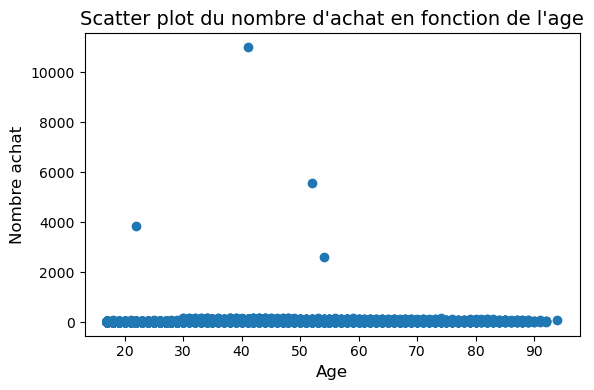

In [107]:
plt.figure(figsize=(6,4))
x=distrib_age_freq['age']
y=distrib_age_freq['nb_sessions']

plt.scatter(x,y)
plt.title("Scatter plot du nombre d'achat en fonction de l'age", fontsize = 14)
plt.xlabel('Age', fontsize = 12)
plt.ylabel('Nombre achat', fontsize = 12)

- Afin de rendre la représentation graphique plus pertinente, nous pouvons créer un nouveau dataframe sans les 4 plus gros clients. 

In [108]:
age_freq = distrib_age_freq.drop(['c_1609', 'c_3454', 'c_4958', 'c_6714'])
age_freq

,CA,nb_sessions,age,sexe
client_id,,,,
c_8526,3975.06,165,56,f
c_1637,4698.87,164,33,f
c_669,4499.36,163,34,m
c_2265,3271.28,163,53,m
c_682,4102.18,161,48,f
...,...,...,...,...
c_7429,85.03,1,29,m
c_450,67.18,1,68,m
c_4478,13.36,1,51,f


Text(0, 0.5, "Nombre d'achat")

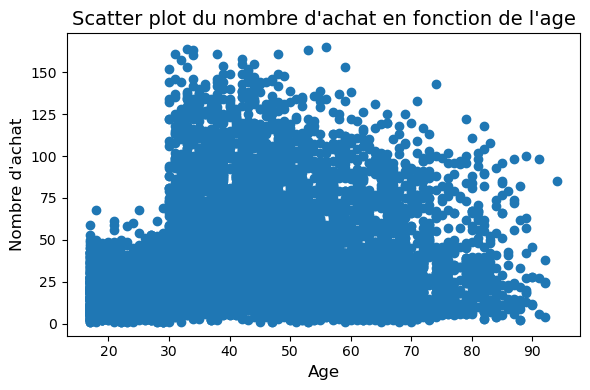

In [109]:
plt.figure(figsize=(6,4))
x=age_freq['age']
y=age_freq['nb_sessions']

plt.scatter(x,y)
plt.title("Scatter plot du nombre d'achat en fonction de l'age", fontsize = 14)
plt.xlabel('Age', fontsize = 12)
plt.ylabel("Nombre d'achat", fontsize = 12)

- De manière générale, nous observons une très faible corrélation entre l'âge et la fréquence d'achat.
- Tout d'abord, les plus jeunes individus (17 - 30 ans) de notre dataframe tendent à effectuer moins d'achats que les plus âgés (31 - 94 ans) de notre dataframe.
- On observe une plus forte fréquence d'achat pour les 31 - 60 ans, ainsi qu'une légère baisse de cette fréquence pour les individus les plus agés de notre dataframe (61 - 94 ans)

##### Test de Mann-Whitney

- Permet de vérifier s'il y a une différence significative entre l'âge des clients et la fréquence d'achat.

In [110]:
u_stat, p_val = mannwhitneyu(age_freq['age'], age_freq['nb_sessions'])
print("Test de Mann-Whitney : U = {:.3f}, p = {:.3f}".format(u_stat, p_val))

Test de Mann-Whitney : U = 48195979.000, p = 0.000


- La valeur du test et la p-value suggère des différences significative entre l'âge et la fréquence d'achat. 
- Cependant, le test de Mann-Whitney ne permet pas de déterminer la nature de cette relation (corrélation positive ou négative)

##### Test de Spearman afin de connaître la force de cette relation

In [111]:
correlation, p_value = spearmanr(age_freq['age'], age_freq['nb_sessions']) # Cette fois, nous testons chaque âge et non chaque catégorie d'âge

print("Coefficient de corrélation de Spearman : ", correlation)
print("P-value : ", p_value)

Coefficient de corrélation de Spearman :  0.2136026765457172
P-value :  2.8496515199491284e-89


- D'après le test de Spearman, il existe une faible corrélation négative entre l'âge et la fréquence d'achat (0.21). Autrement dit, plus l'âge augmente, plus la fréquence d'achat augmente. 
- La p-value associée (2.85e-89) extrêment faible suggère que cette relation est statistiquement robuste, bien que la force de cette relation soit faible. 

<h2 style="font-size:19px;color:blue"> Quel est le lien entre l'âge et la catégorie de livre achetée ? </h2>

##### Quantitative x Qualitative

- Nous avons précedement vu que l'âge dans nos données ne suivait pas une loi normale. L'utilisation d'un test non paramétrique comme le test de Kruskal Wallis est necessaire afin de déterminer le lien entre l'âge et les catégories de livres achetées.
- Ce test permet de savoir si un groupe diffère significativement des autres. 

In [112]:
# Avant de procéder aux vérifications, nous séparons l'âge et la catégorie de livre acheté
cat_0 = distrib_age[distrib_age['categ'] == 0]['age']
cat_1 = distrib_age[distrib_age['categ'] == 1]['age']
cat_2 = distrib_age[distrib_age['categ'] == 2]['age']

##### Test de Kruskal-Wallis 

In [113]:
H, p = kruskal(cat_0, cat_1, cat_2)
alpha = 0.05
if p > alpha:
    print('Les moyennes des groupes ne sont pas significativement différentes (p = %.3f)' % p)
else:
    print('Au moins une des moyennes des groupes est significativement différente (p = %.3f)' % p)

Au moins une des moyennes des groupes est significativement différente (p = 0.000)


- Le test de Kruskal-Willis et sa p-value de 0.00 atteste du lien statistique entre l'âge et les catégories de livres achetées.
- Parmi les 3 catégories de livres achetées, en fonction de l'âge, une des catégories diffère significativement de l'autre. Pour savoir laquelle diffère, où si chacune diffère des autres, nous allons réaliser la matrice de comparaison de Dunn.

##### Matrice de comparaison de Dunn

In [114]:
age_dunn = sp.posthoc_dunn([cat_0, cat_1, cat_2])
print(age_dunn)

     1    2    3
1  1.0  0.0  0.0
2  0.0  1.0  0.0
3  0.0  0.0  1.0


- Ce tableau représente la matrice de comparaison de Dunn. Chaque valeur représente la p-val associé à la comparaison de chaque catégories de livres achetées par rapport aux autres, toujours en fonction de l'âge. 
- Ici, chaque groupe est significativement différent les uns des autres. La p-val = 0.0 pour chaque groupes par rapport aux autres.

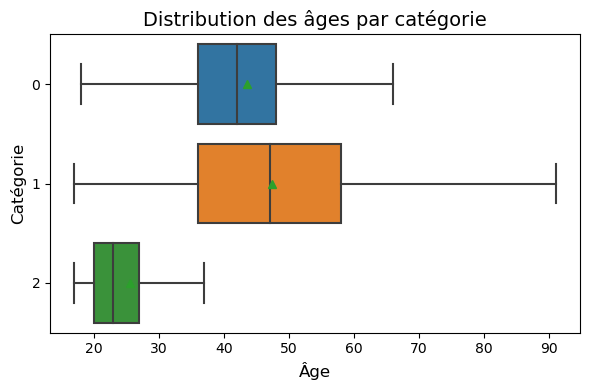

In [115]:
plt.figure(figsize=(6,4))
sns.boxplot(data=distrib_age, x='age', y='categ', orient='h', showfliers=False, showmeans=True)
plt.title('Distribution des âges par catégorie', fontsize = 14)
plt.xlabel('Âge', fontsize = 12)
plt.ylabel('Catégorie', fontsize = 12)
plt.show()

- Graphiquement, nous observons de très fortes différences entre l'âge des acheteurs de catégorie 2 par rapport à l'âge des clients de catégorie 0 et 1. 
- En moyenne, les acheteurs de livres de catégorie 0 ont 44 ans, ceux de la catégorie 1 ont 47 ans et 26 ans concernant la catégorie 2.

<h2 style="font-size:19px;color:blue"> Corrélation à l'achat des différentes catégories de livres </h2>

##### Heatmap de corrélation entre les catégories de livres achetés

<AxesSubplot:xlabel='categ', ylabel='categ'>

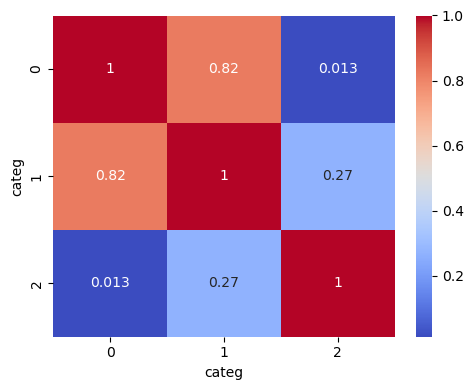

In [116]:
heatmap_categ = pd.pivot_table(data=transac_prod_cust, values='session_id', index='client_id', columns='categ', aggfunc='count')
corr_matrix = heatmap_categ.corr(method='pearson') # Corrélation Pearson

plt.figure(figsize=(5,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')


- Plus la couleur tend vers le chaud (rouge) et plus les catégories sont susceptibles d'être acheté ensemble.
- A l'inverse, les couleurs froides (bleues) signifie que les catégories de livres sont rarement achetée ensemble. 

- On observe une très forte corrélation positive entre les catégories 0 et 1. Les livres de catégories 0 sont très fréquement acheté avec des livres de catégories 1,  et vice-versa.
- La relation entre la catégorie 0 et 2 est quand à elle quasiment innexistante. Le coefficient de corrélation de 0.0076 indique qu'il est extrêmement rare qu'un acheteur de livres de catégories 0 achète également un livre de catégorie 2.
- Enfin, la relation entre la catégorie 1 et 2 est modérée. Les livres des catégories 1 et 2 sont modérément achetés ensemble.